In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
Mon Jun  3 15:29:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1A:00.0 Off |                  N/A |
| 31%   35C    P8               5W / 250W |   5375MiB / 11264MiB |      0%      Default |
|                                         |               

In [4]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[15:29:17.723] INFO   CaloQVAE                                          Willkommen!
[15:29:17.727] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2024-06-03 15:29:22,963 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[15:29:22.963] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[15:29:30.178] INFO   data.dataManager                                  Loading Data
[15:29:45.905] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7bdde001f0>: 80000 events, 625 batches
[15:29:45.908] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7bdd929bb0>: 10000 events, 10 batches
[15:29:45.909] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7bdd929a00>: 10000 events, 79 batches
[15:29:51.010] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPCRBMCNN
2024-06-03 15:29:51,014 dwave.c

Initializing NetworkV3


In [8]:


# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[15:29:57.590] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[15:30:02.632] INFO   engine.engineAtlas                                Setting up engine Atlas.
[15:30:02.633] INFO   engine.engineCaloV3                               Setting up engine Calo.
[15:30:02.634] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[15:30:15.400] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c56afdf40>: 80000 events, 625 batches
[15:30:15.403] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c56af7160>: 10000 events, 10 batches
[15:30:15.403] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c56af7700>: 10000 events, 79 batches


In [10]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [11]:
# winter-snowflake-24: GumBoltAtlasPRBMCNN
# run_path = "/fast_scratch/sgonzalez/wandb/run-20240228_120832-q78nzust/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"

# run_path = "/fast_scratch/sgonzalez/wandb/run-20240313_155921-4q9i8pnt/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'macabre-candle-1372'
# datascaled = 'scaled'
# with open("/fast_scratch/sgonzalez/wandb/run-20240313_155921-4q9i8pnt/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     #R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     #reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False

# change this directory to load the synthetic data

# run_path = "/fast_scratch/QVAE/syn_data/dataset2_synthetic_macabre-candle-1372v2.hdf5"

run_path = "/fast_scratch/sgonzalez/wandb/run-20240422_172049-e167mmxd/files/GumBoltAtlasPCRBMCNN_atlas_default_best.pth"
modelname = 'macabre-candle-1372'
datascaled = 'scaled'
with open("/fast_scratch/sgonzalez/wandb/run-20240422_172049-e167mmxd/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    #R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    #reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False


arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasPCRBMCNN
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [12]:
# engine.con

# Test data: /fast_scratch/QVAE/test_data/dataset_2_2.hdf5
# Synthetic data: /fast_scratch/QVAE/syn_data/dataset2_synthetic_macabre-candle-1372v2.hdf5

In [13]:
xtarget_samples = []
xrecon_samples = []
xgen_samples = []
scaled = True
entarget_samples = [] #in MeV

def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v
            
# for xx in train_loader:
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
    fwd_output = engine.model((in_data, true_energy), False)
    
    if scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        
        
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        
        ## This is how youi generate data using model
        # ================================
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples_qpu(num_samples=128, true_energy=true_energy[:128])
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        # ================================
    
    else:
        raise Exception("Script only supports scaled dataset at the moment...")


    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
# use these
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

In [14]:
# Data from good model
import h5py
gen_samps = h5py.File('/fast_scratch/QVAE/syn_data/wise-tree-1429.hdf5', 'r')
print(len(gen_samps))
print(gen_samps.keys())
print((gen_samps['incidence energy']).shape)
print((gen_samps['showers']).shape)
print(xtarget_samples.numpy().shape)

2
<KeysViewHDF5 ['incidence energy', 'showers']>
(100000, 1)
(100000, 6480)
(10000, 6480)


In [15]:
# entarget_samples = gen_samps['incidence energy']
xgen_samples = (torch.tensor(gen_samps['showers']))
print(xgen_samples)

tensor([[ 0.0000, 14.8557, 16.3141,  ...,  0.0000, 18.1369,  0.0000],
        [12.9759,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 16.4827,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [13.6804,  0.0000, 17.0332,  ...,  0.0000,  0.0000,  0.0000],
        [13.7379,  0.0000, 16.0922,  ...,  0.0000,  0.0000,  0.0000]])


/tmp/ipykernel_165238/693399587.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
  xgen_samples = (torch.tensor(gen_samps['showers']))


In [16]:
print(xtarget_samples, xtarget_samples.shape)
print(entarget_samples, entarget_samples.shape)
print(entarget_samples[(9900 < entarget_samples) & (entarget_samples < 10100)])

tensor([[ 2.8870,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.4611,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.4747,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([10000, 6480])
tensor([[  2128.1135],
        [  3865.5706],
        [256267.9375],
        ...,
        [688751.9375],
        [145378.1875],
        [  6909.7441]]) torch.Size([10000, 1])
tensor([10098.4209,  9951.5391,  9914.6445, 10041.1602, 10064.9814,  9926.7246,
        10030.1934, 10076.0771,  9908.6172,  9984.3320,  9956.0488, 10044.0020,
        10086.3711,  9947.4434, 10025.9844,  9999.0186,  9906.5127, 10065.3350,
         9978.7900, 10071.6328,  9972.4814, 10040.8398,  9901.2803, 10056.3516,
        10097.2920, 10056.2520, 10020.7852, 1

In [17]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

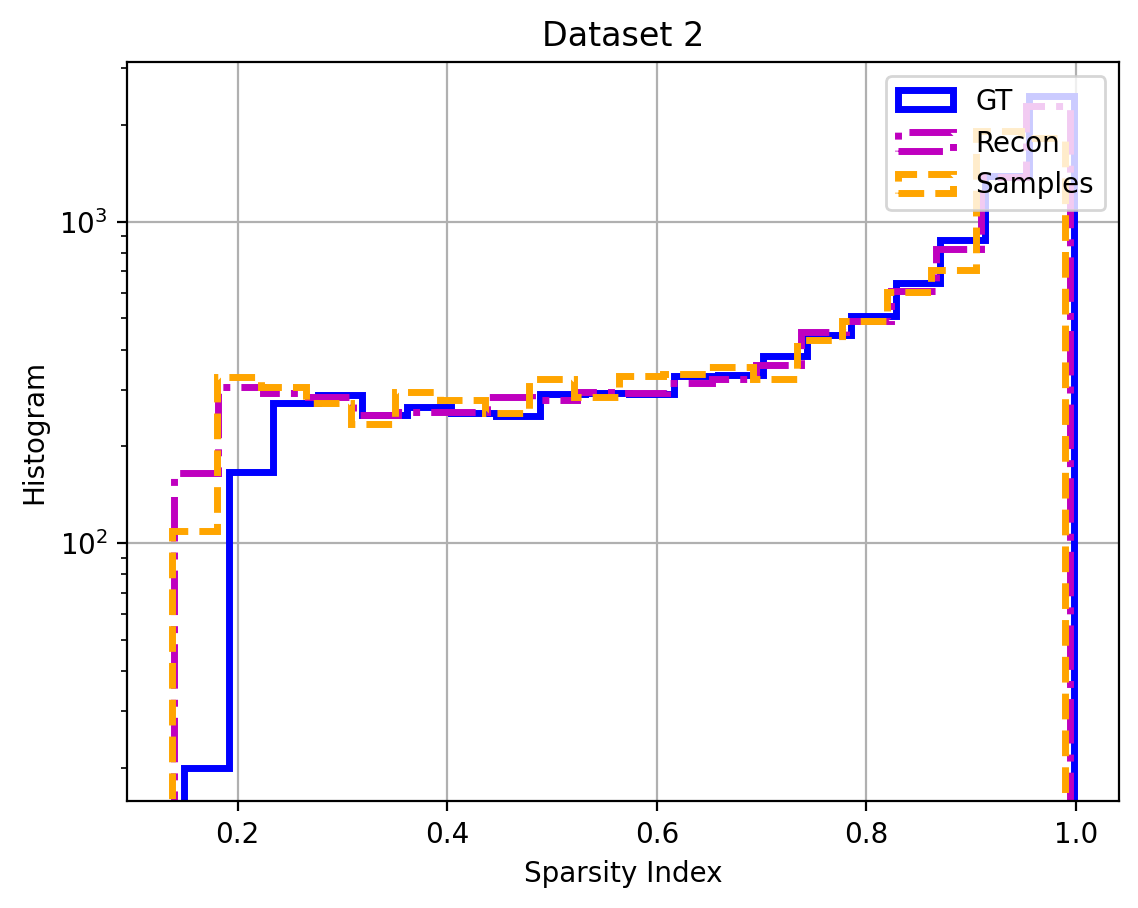

In [18]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist((xgen_samples == 0).sum(axis=1) / xtarget_samples.shape[1], bins=20, weights=np.ones_like((xgen_samples == 0).sum(axis=1) / xtarget_samples.shape[1]) * 0.1, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")

plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.show()

720 0
1440 720
2160 1440
2880 2160
3600 2880
4320 3600
5040 4320
5760 5040
6480 5760


<Figure size 800x600 with 0 Axes>

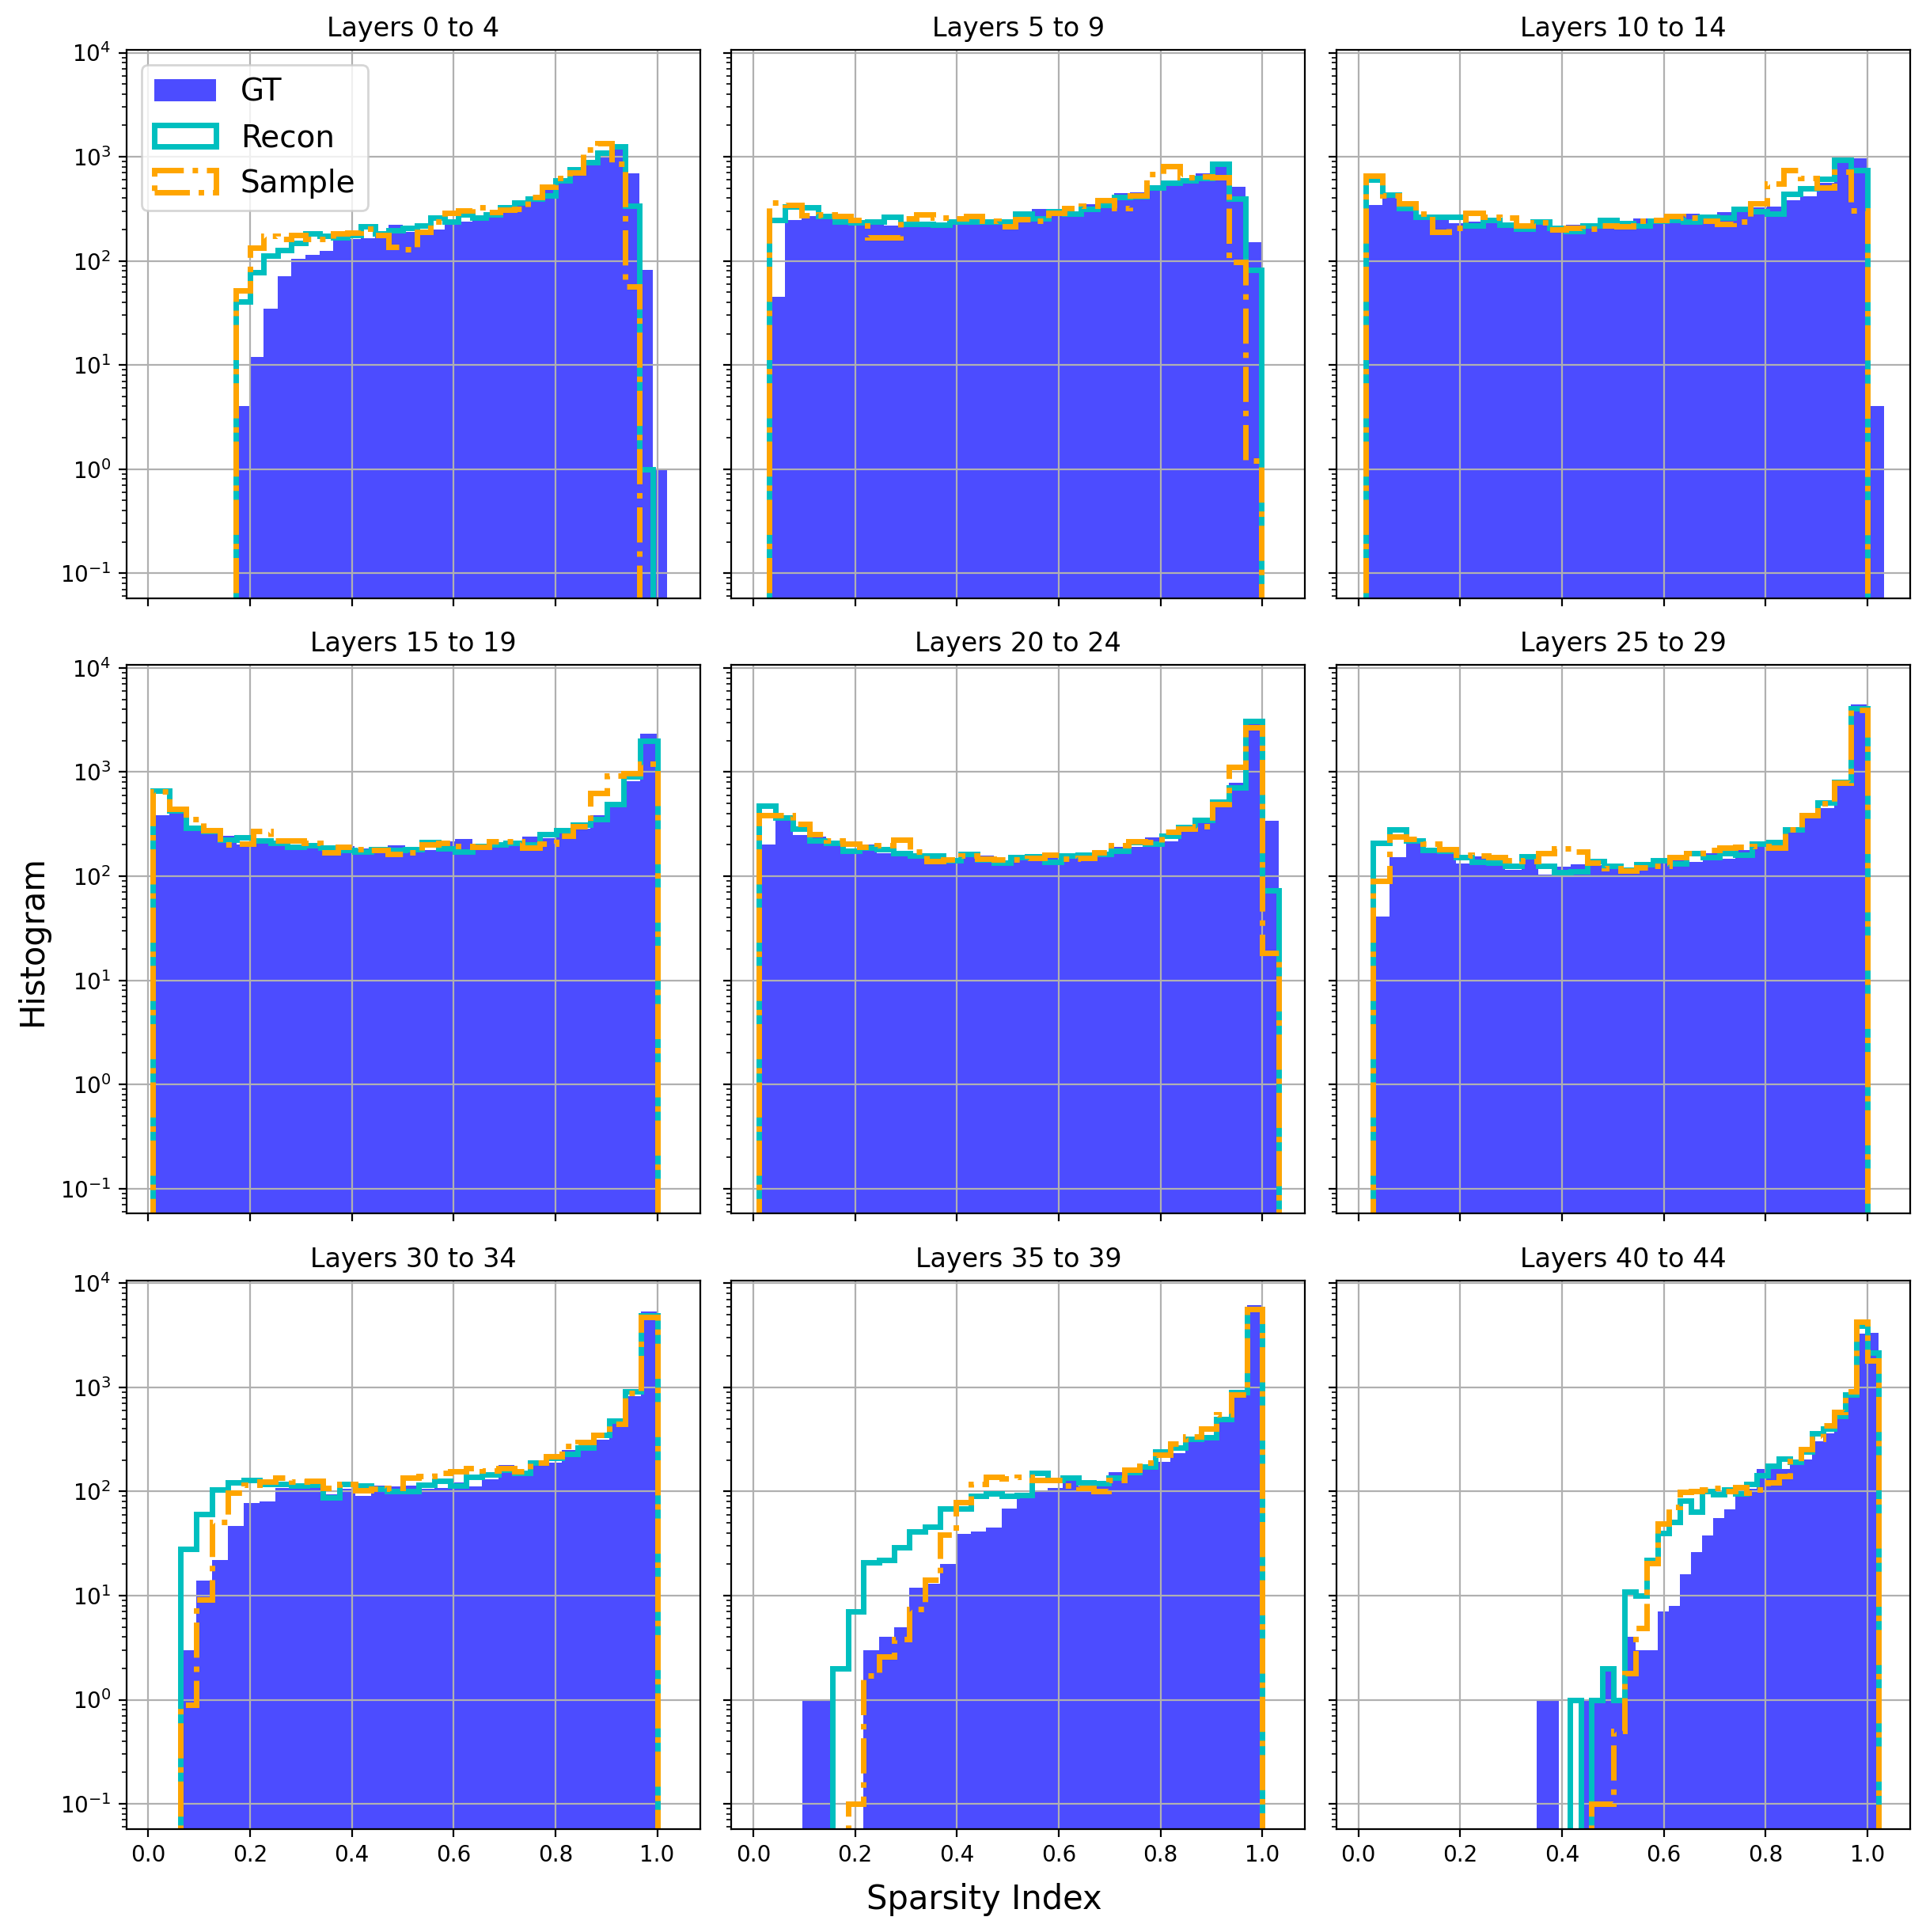

In [47]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]

# Create lists for the histogram values
target_counts, recon_counts, sample_counts = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)
target_bins, recon_bins, sample_bins = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    print(idx, idxPrev)
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    
    # Store the values of the histogram with the same normalization and bin sizes
    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    sample_counts[i], sample_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal+binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal+binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal+binwidth, binwidth), weights = np.ones_like((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l) * 0.1, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14, loc = 'upper left')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

<Figure size 800x600 with 0 Axes>

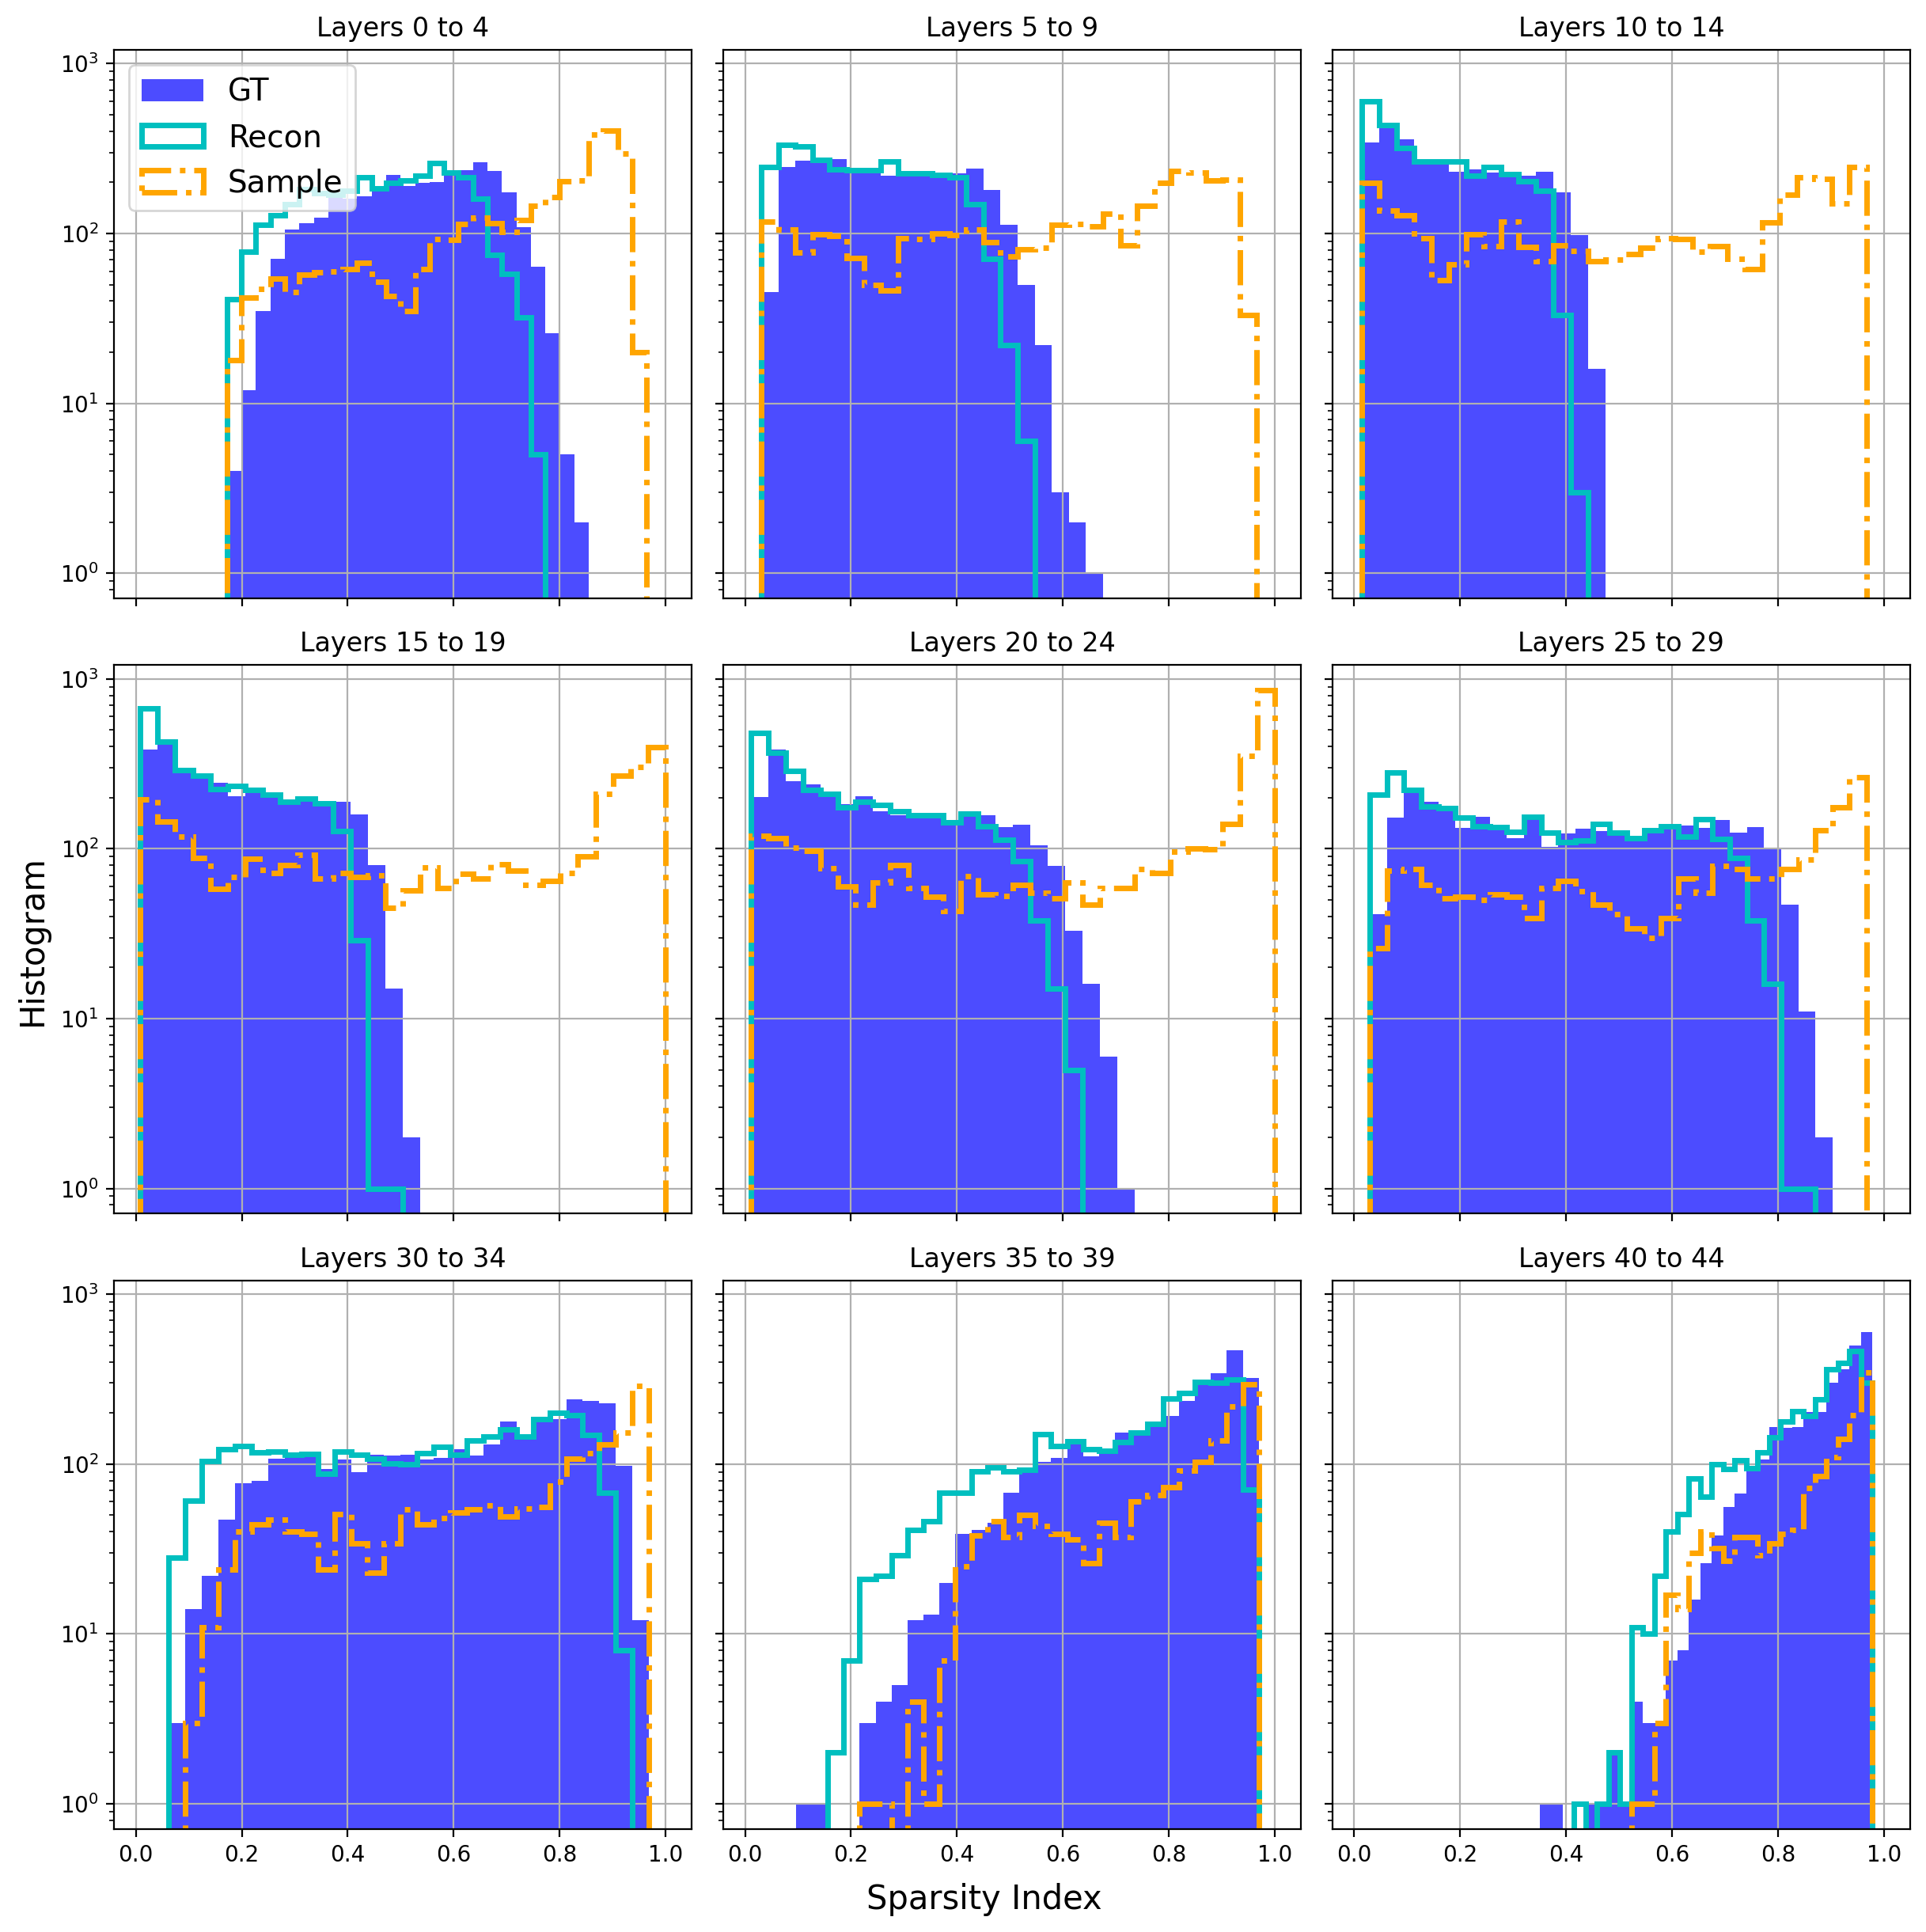

In [20]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]

# Energy Ranges
E_right = 50000000000
E_left = 100000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]

# Create lists for the histogram values
target_counts, recon_counts, sample_counts = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)
target_bins, recon_bins, sample_bins = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    
    # Store the values of the histogram with the same normalization and bin sizes
    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    sample_counts[i], sample_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    ax.hist((((xtarget_samples[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist((((xrecon_samples[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    ax.hist((((xgen_samples[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14, loc = 'upper left')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

5760 6480
torch.Size([10000, 6480])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([720, 718, 670,  ..., 602, 702, 720])
[1.         0.99722224 0.9305556  ... 0.8361111  0.975      1.        ] (10000,)


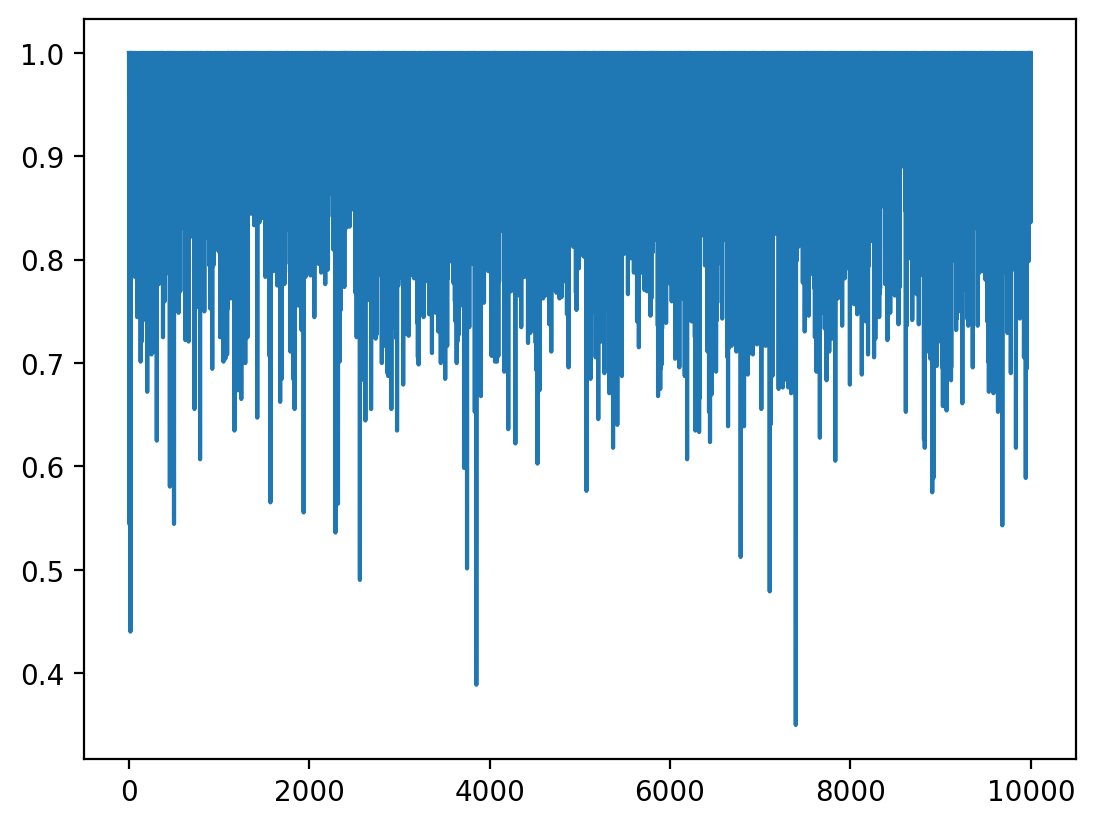

[   4   12   35   71  105  115  124  163  161  166  187  221  191  198
  200  222  238  275  280  311  348  409  481  557  765  925 1149 1313
  691   82    1] [  41   78  112  128  148  183  173  169  178  214  184  198  206  218
  259  239  277  262  277  327  360  396  428  592  753  888 1088 1257
  341    1    0]
KL div b/w target and recon:  inf
KL div b/w target and gen:  0.022869027547782753


/tmp/ipykernel_165238/3362740522.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  KL_met += target[i] * np.log(abs(target[i]/inp[i]))


In [21]:
def KL_div(target, inp):
    KL_met = 0
    for i in range(min(len(inp), len(target))):
        if target[i] == 0:
            KL_met += 0
        else:
            KL_met += target[i] * np.log(abs(target[i]/inp[i]))
    return KL_met / min(len(inp), len(target))

def Hellinger_dist(target, inp):
    Hel_dist = 0
    for i in range(min(len(inp), len(target))):
        Hel_dist += ((target[i]) ** 0.5 - (inp[i]) ** 0.5) ** 2
    return (1 / (2 ** 0.5)) * ((Hel_dist) ** 0.5)

print(idxPrev, idx)
print(xtarget_samples.size()) # [# of data cylinders, # voxels per cylinder]
print((xtarget_samples[:, idxPrev:idx] == 0))
# l = idx = idxPrev
print((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1))
print(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy().shape)

plt.plot(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
plt.show()

print(target_counts[0], recon_counts[0])
print("KL div b/w target and recon: ", KL_div(target_counts[0], recon_counts[0]))
print("KL div b/w target and gen: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()))

Layer Size:  45
JSD Size:  45


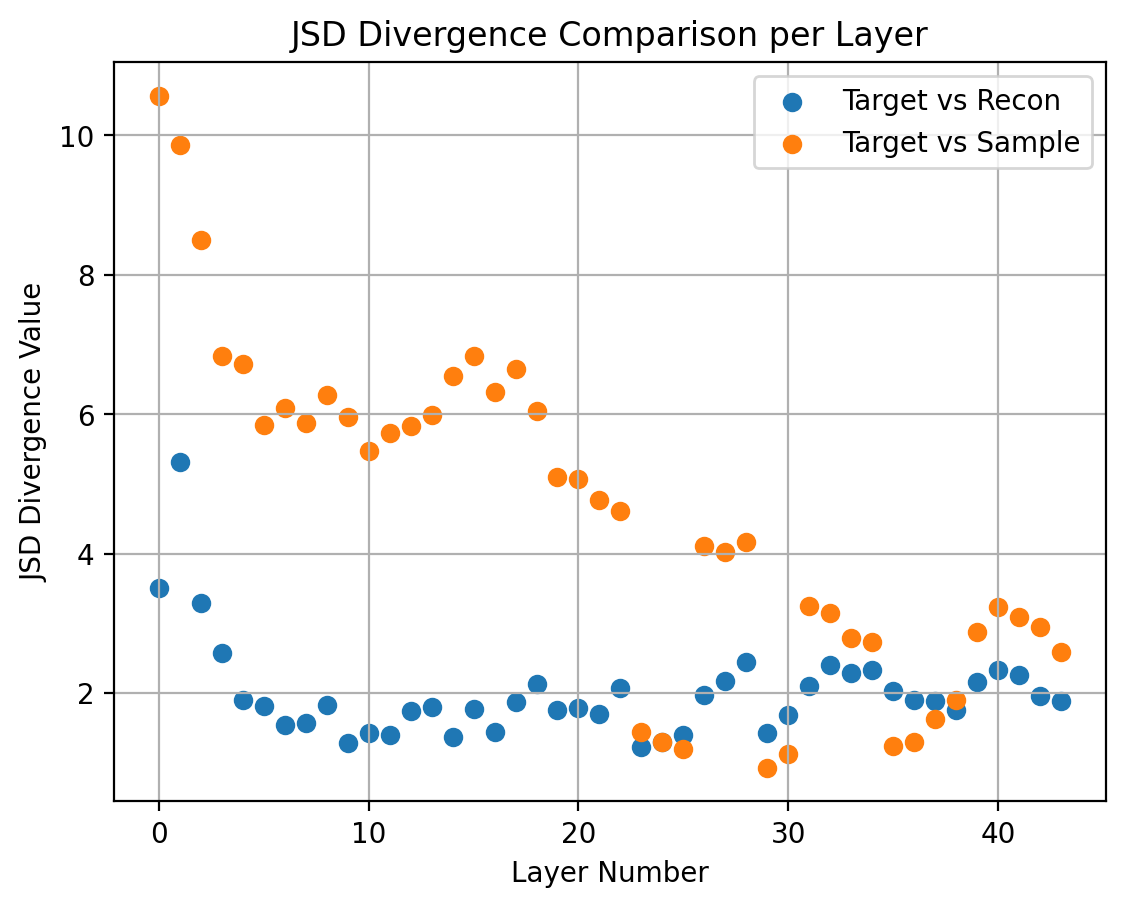

In [48]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros(45)
JSD_gen = np.zeros(45)

HLD_recon = np.zeros(45)
HLD_gen = np.zeros(45)

# Create lists for the histogram values
target_counts, recon_counts, gen_counts = [0] * 44, [0] * 44, [0] * 44
target_bins, recon_bins, gen_bins = [0] * 44, [0] * 44, [0] * 44

for i in range(44): # of layers in the cylinder - 1
    idx = (i+1)*9*16
    idxPrev = (i)*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    gen_counts[i], gen_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), weights = np.ones_like((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l) * 0.1)
    mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
    mid_gen = 0.5 * (target_counts[i] + gen_counts[i])
    
#     print(mid_recon, target_counts[0].tolist())
    
#     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
#     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))
   
    JSD_recon[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
    JSD_gen[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))
    
    HLD_recon[i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
    HLD_gen[i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

print("Layer Size: ", layers.size)
print("JSD Size: ", len(JSD_recon))
plt.scatter(layers[:-1], np.asarray(JSD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(JSD_gen[:-1]))

plt.xlabel("Layer Number")
plt.ylabel("JSD Divergence Value")
plt.legend(["Target vs Recon", "Target vs Sample"])
plt.title("JSD Divergence Comparison per Layer")
plt.grid("True")
plt.show()

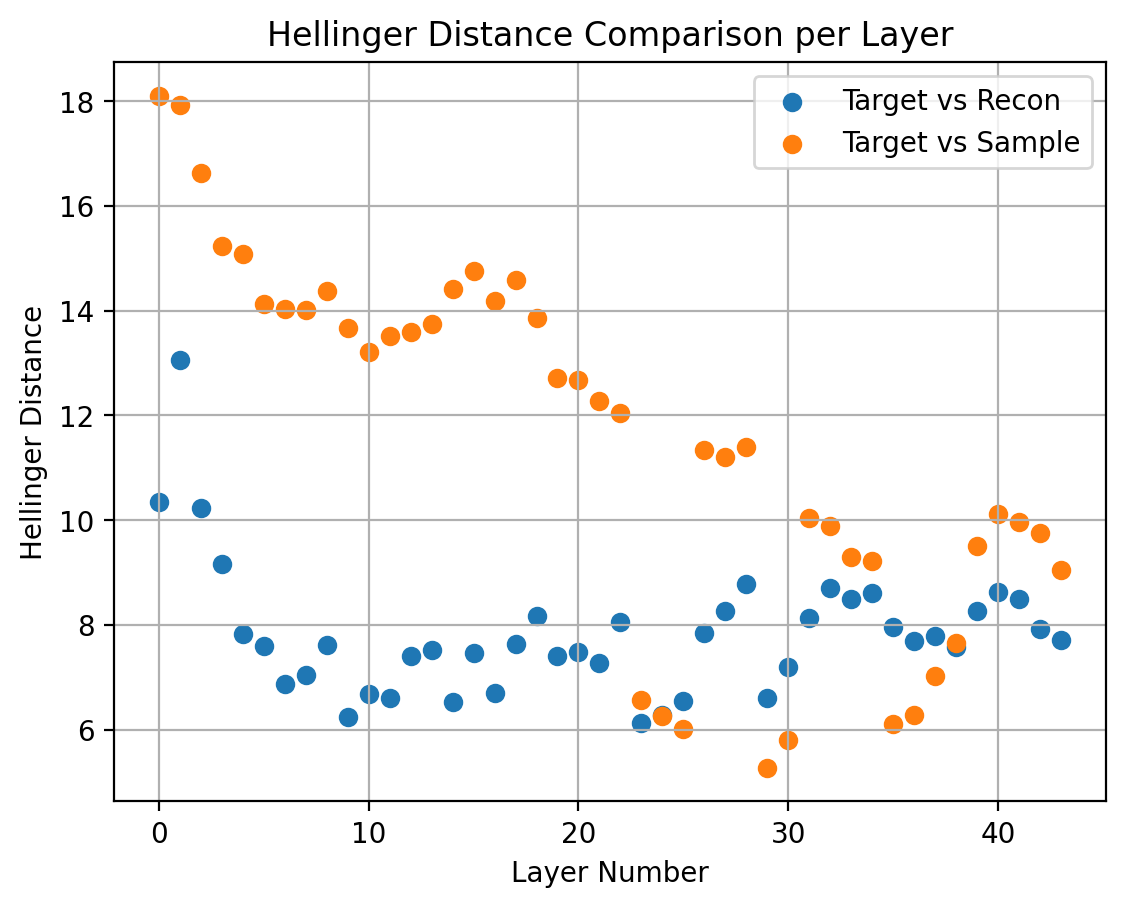

In [49]:
plt.scatter(layers[:-1], np.asarray(HLD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(HLD_gen[:-1]))

plt.xlabel("Layer Number")
plt.ylabel("Hellinger Distance")
plt.legend(["Target vs Recon", "Target vs Sample"])
plt.title("Hellinger Distance Comparison per Layer")
plt.grid("True")
plt.show()

In [24]:
print(entarget_samples)
entarget_samplesnp = entarget_samples.numpy()
ind = np.argsort(entarget_samplesnp, axis = 0).flatten()
print(ind)
print(entarget_samples[ind])
sortxtarget_samples = xtarget_samples[ind]
print(sortxtarget_samples, sortxtarget_samples.shape)
print(max(sortxtarget_samples[0]))

tensor([[  2128.1135],
        [  3865.5706],
        [256267.9375],
        ...,
        [688751.9375],
        [145378.1875],
        [  6909.7441]])
[4822 5052 7533 ... 5073 2685 4081]
tensor([[  1000.6120],
        [  1000.9676],
        [  1001.0806],
        ...,
        [998273.3125],
        [998893.5000],
        [999325.5000]])
tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.7689,   0.0000,   0.4399,  ...,   0.0000,   0.0000,   0.0000],
        [110.5438,  13.5819,   0.0000,  ...,  20.7071,   0.0000,   2.7768],
        [  0.0000,   0.0000,   4.8029,  ...,   0.0000,   4.2236,   0.0000]]) torch.Size([10000, 6480])
tensor(68.0380)


In [25]:
# test = np.logspace(0, np.log(1000000), 44, base=10)
# print(test)

# idxPrev = test[0]
# print(entarget_samples, entarget_samples.shape)
# for i in range(44):
#     print(len(entarget_samples[:, int(test[i]): int(test[i+1])]))

x=np.zeros([4,4])
x[0][0] = 1
print(x)

samps = np.linspace(0, 44, 12)
print(samps)

[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[ 0.  4.  8. 12. 16. 20. 24. 28. 32. 36. 40. 44.]


[[0.01026663 0.71003663 0.22254085 ... 0.         0.         0.        ]
 [0.01854127 0.86220737 0.57603367 ... 0.         0.         0.        ]
 [0.00923967 0.50928239 0.23583543 ... 0.         0.         0.        ]
 ...
 [1.70725522 1.26948331 1.24292075 ... 1.0655926  1.06689416 0.96995576]
 [1.66877791 1.36489864 1.57288705 ... 1.49276418 1.40617331 1.45648867]
 [1.69277849 1.15386269 1.36472709 ... 1.95830163 1.67981502 1.62877152]] (44, 44)


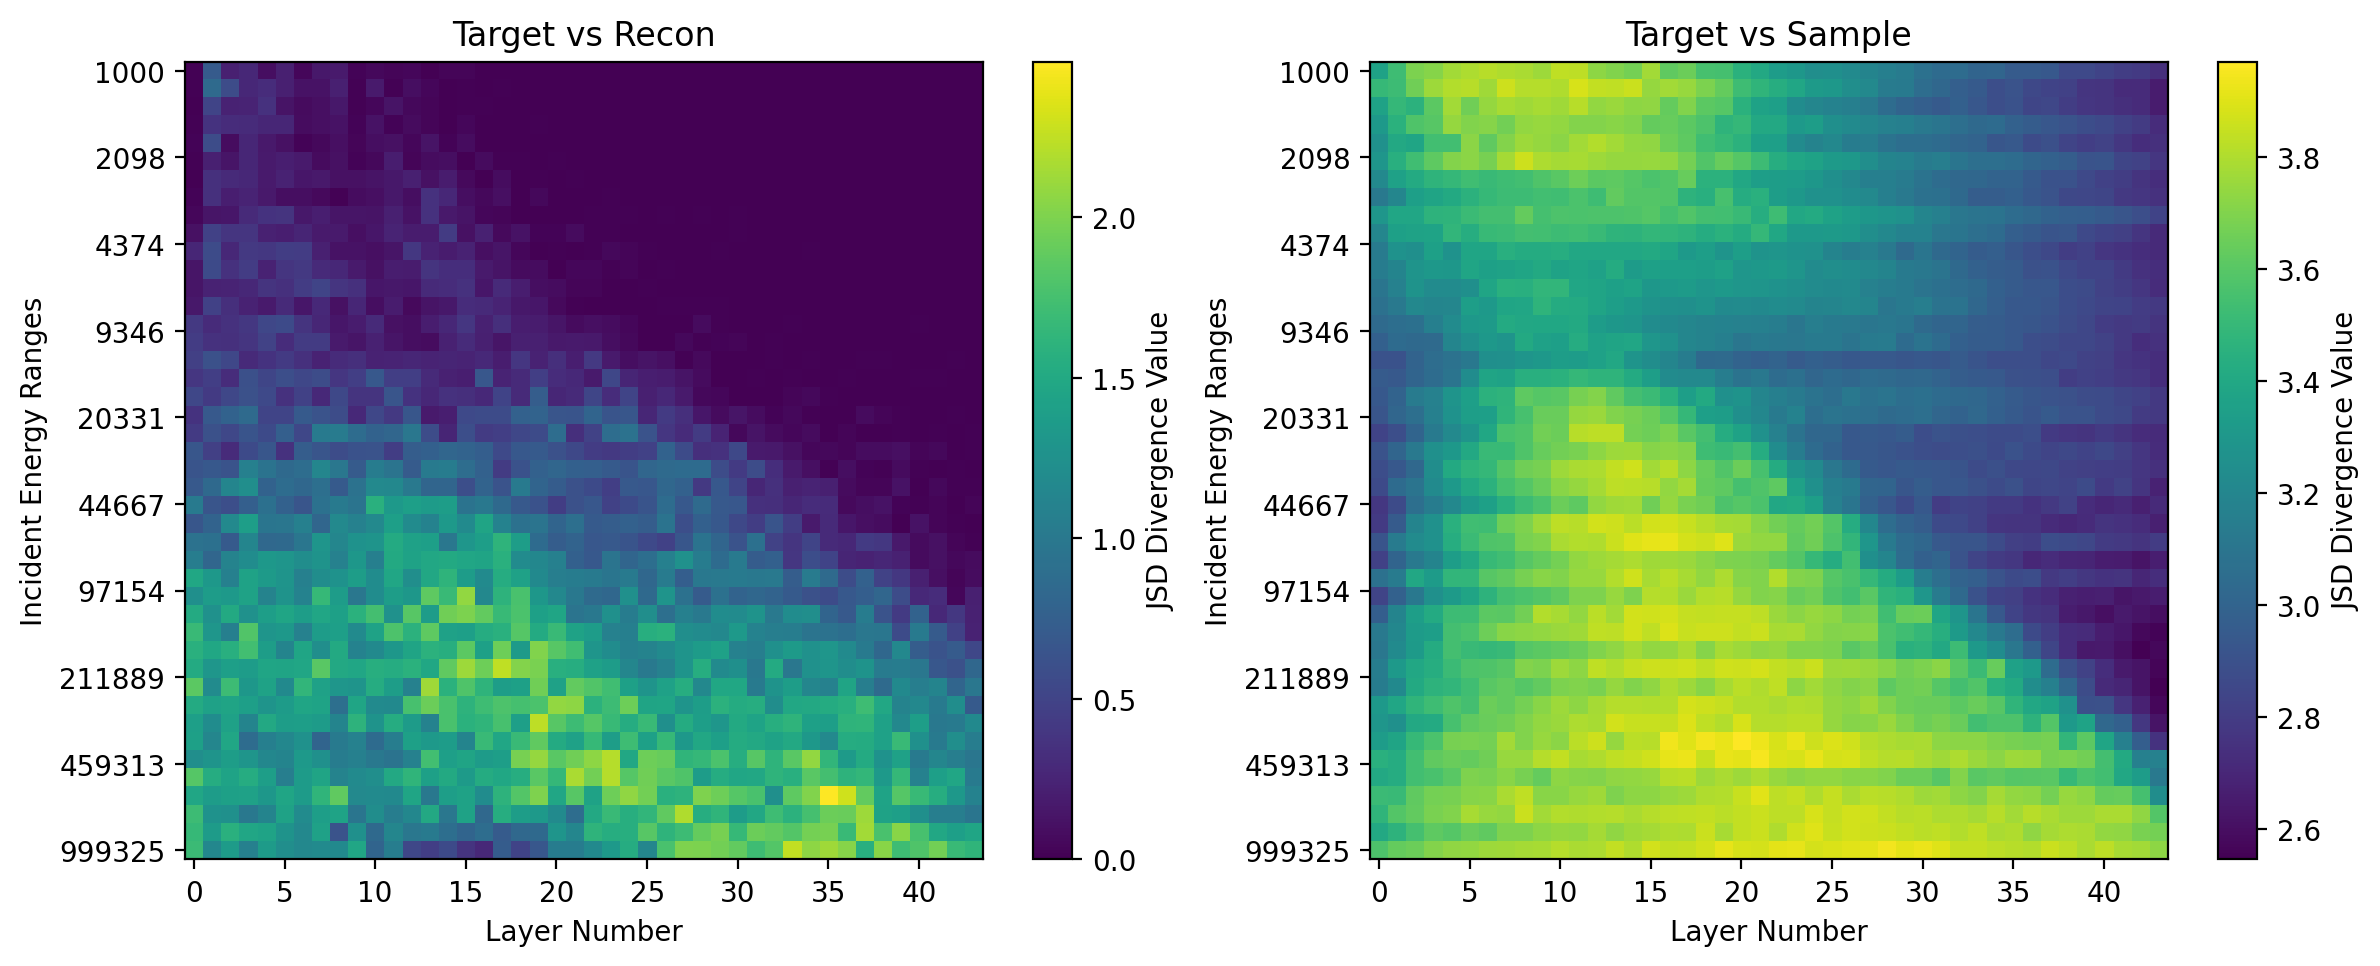

In [52]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0
from mpl_toolkits.axes_grid1 import make_axes_locatable

samps = np.linspace(0, len(entarget_samples) - 1, 10)

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros([44,44])
JSD_gen = np.zeros([44,44])

HLD_recon = np.zeros([44,44])
HLD_gen = np.zeros([44,44])

# Sort samples
entarget_samplesnp = entarget_samples.numpy()
ind = np.argsort(entarget_samplesnp, axis = 0).flatten()
sortentarget_samples = entarget_samples[ind]
sortxtarget_samples = xtarget_samples[ind]
sortxrecon_samples = xrecon_samples[ind]
sortxgen_samples = xgen_samples[ind]
inc_energies = np.linspace(0, len(entarget_samples), 46).astype(int)

xenergies = (((sortentarget_samples[samps] / 1).flatten()).numpy().astype(int)).tolist()

minVal, maxVal = 0, 1
binwidth = (maxVal-minVal)/20

for j in range(44):
    
    # Create lists for the histogram values
    target_counts, recon_counts, gen_counts = [0] * 44, [0] * 44, [0] * 44
    target_bins, recon_bins, gen_bins = [0] * 44, [0] * 44, [0] * 44

    
    sub_target_samples = sortxtarget_samples[inc_energies[j] : inc_energies[j+1]]
    sub_recon_samples = sortxrecon_samples[inc_energies[j] : inc_energies[j+1]]
    sub_gen_samples = sortxgen_samples[inc_energies[j] : inc_energies[j+1]]

    for i in range(44): # of layers in the cylinder - 1
#         print(sub_target_samples, sub_target_samples.shape)

        idx = (i+1)*9*16
        idxPrev = (i)*9*16
        l = idx - idxPrev
        
        target_counts[i], target_bins[i] = np.histogram(((sub_target_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
        recon_counts[i], recon_bins[i] = np.histogram(((sub_recon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
        gen_counts[i], gen_bins[i] = np.histogram(((sub_gen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), weights = np.ones_like((sub_gen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l) * 0.1)
        mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
        mid_gen = 0.5 * (target_counts[i] + gen_counts[i])

    #     print(mid_recon, target_counts[0].tolist())

    #     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
    #     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))
    
        JSD_recon[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
        JSD_gen[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))

        HLD_recon[j][i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
        HLD_gen[j][i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

# print(JSD_recon)
# print(min(JSD_recon.flatten()))
print(JSD_recon, JSD_recon.shape)

# Plotting for JSD_recon and JSD_gen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for JSD_recon
cax1 = ax1.imshow(JSD_recon, interpolation='nearest', cmap='viridis')
ax1.set_aspect('equal')
ax1.set_title("Target vs Recon")
ax1.set_yticks(np.linspace(0, 43, 10))
ax1.set_yticklabels([int(x) for x in xenergies])
ax1.set_ylabel("Incident Energy Ranges")
ax1.set_xlabel("Layer Number")
divider1 = make_axes_locatable(ax1)
cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
cbar1.set_label('JSD Divergence Value')

# Plot for JSD_gen
cax2 = ax2.imshow(JSD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_title("Target vs Sample")
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('JSD Divergence Value')

plt.tight_layout()
plt.show()

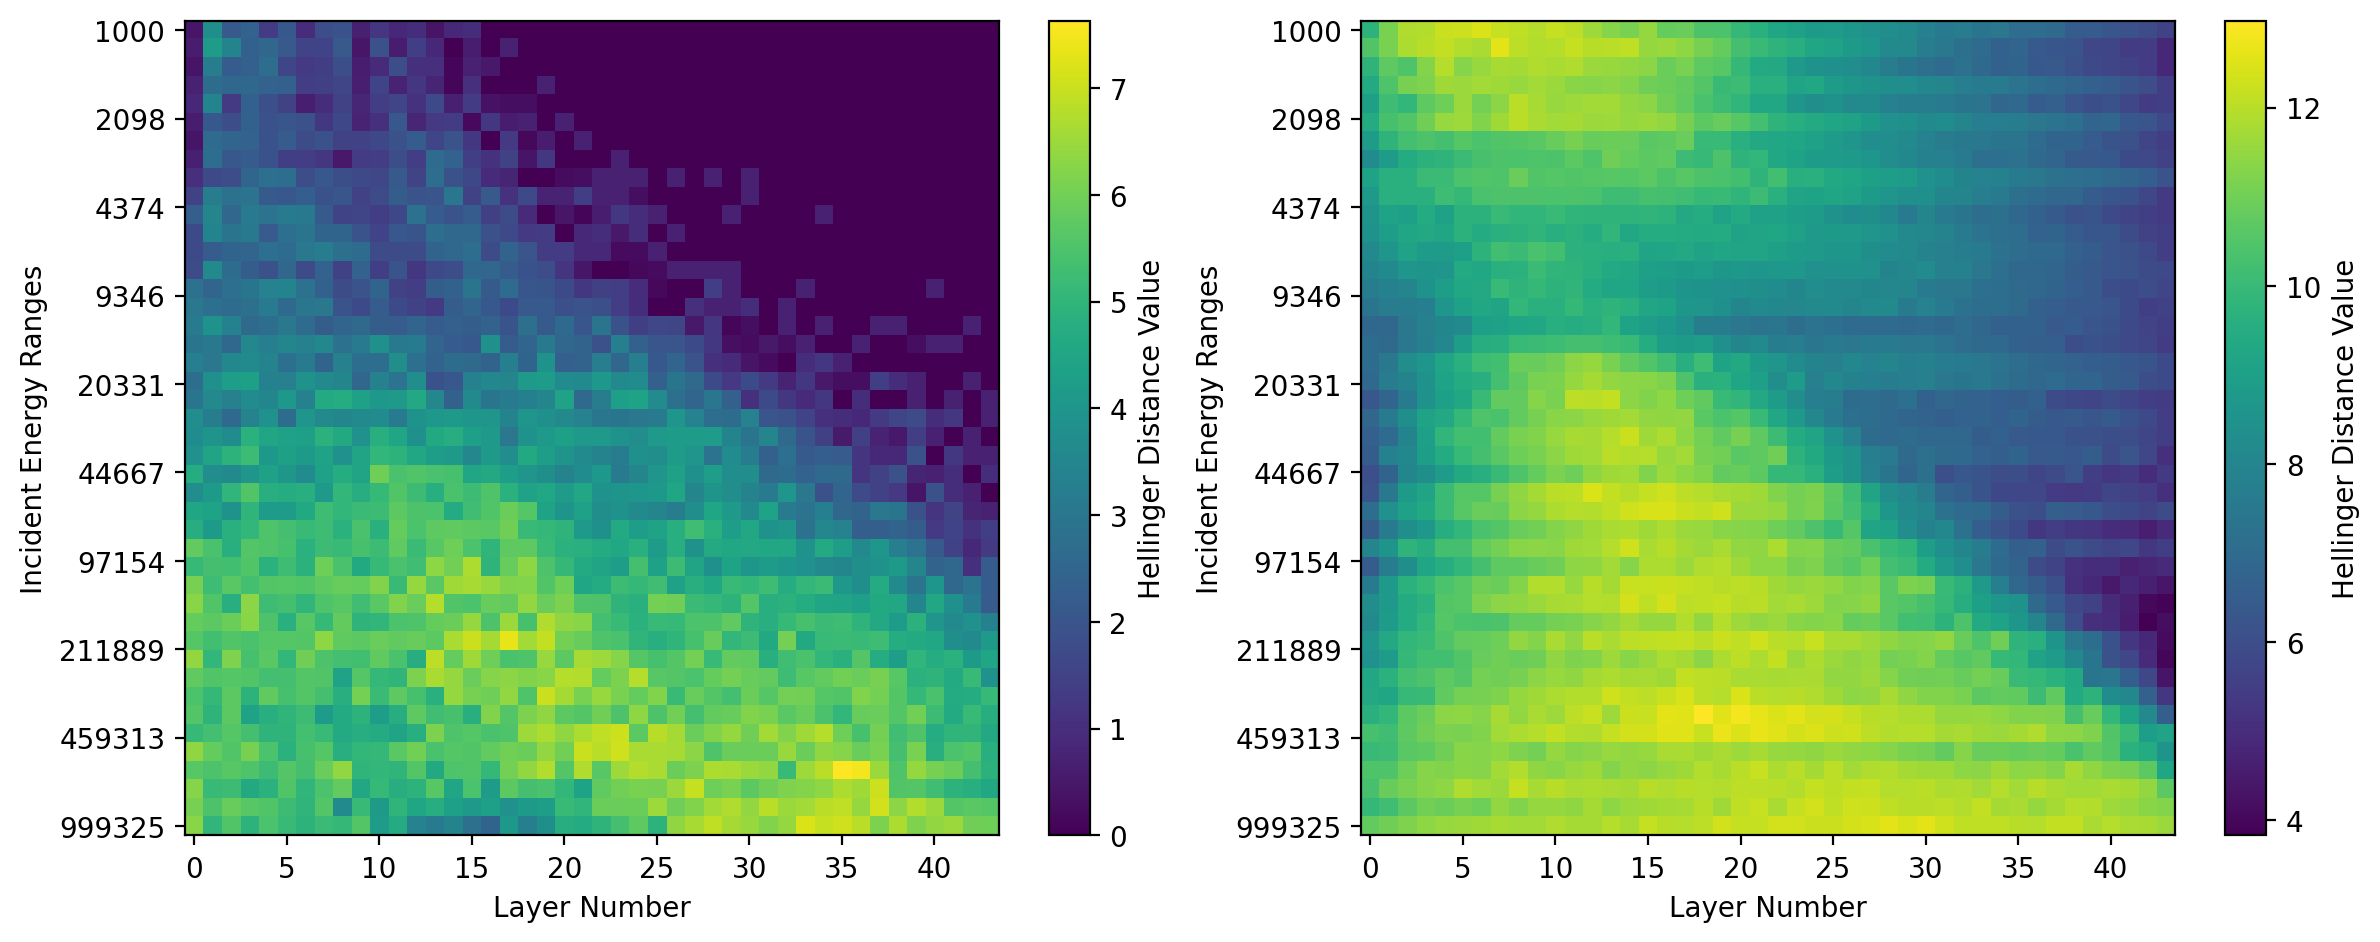

In [27]:
# Plotting for HLD_recon and HLD_gen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for HLD_recon
cax1 = ax1.imshow(HLD_recon, interpolation='nearest', cmap='viridis')
ax1.set_aspect('equal')
ax1.set_yticks(np.linspace(0, 43, 10))
ax1.set_yticklabels([int(x) for x in xenergies])
ax1.set_ylabel("Incident Energy Ranges")
ax1.set_xlabel("Layer Number")
divider1 = make_axes_locatable(ax1)
cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
cbar1.set_label('Hellinger Distance Value')

# Plot for HLD_gen
cax2 = ax2.imshow(HLD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('Hellinger Distance Value')

plt.tight_layout()
plt.show()


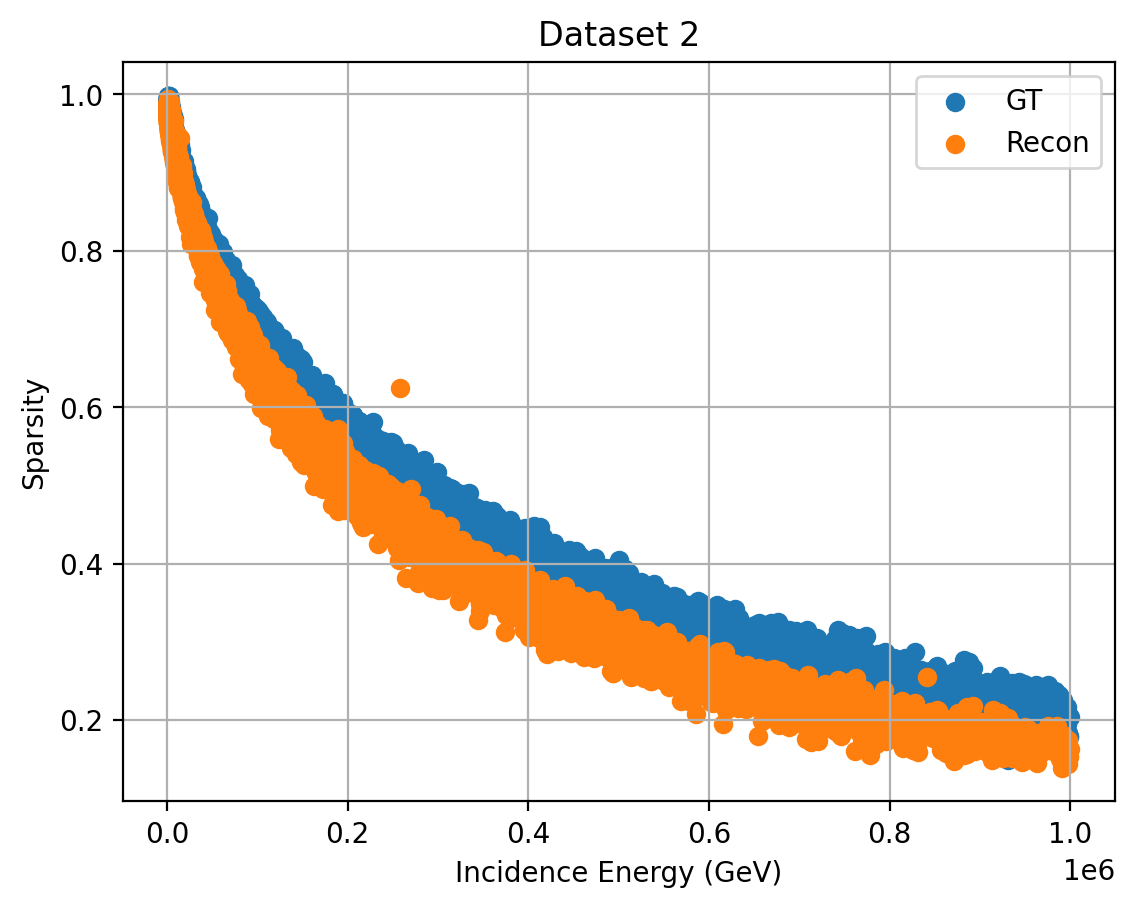

In [28]:
plt.scatter(entarget_samples, ((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())
plt.scatter(entarget_samples, ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())

plt.xlabel("Incidence Energy (GeV)")
plt.ylabel("Sparsity")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.show()

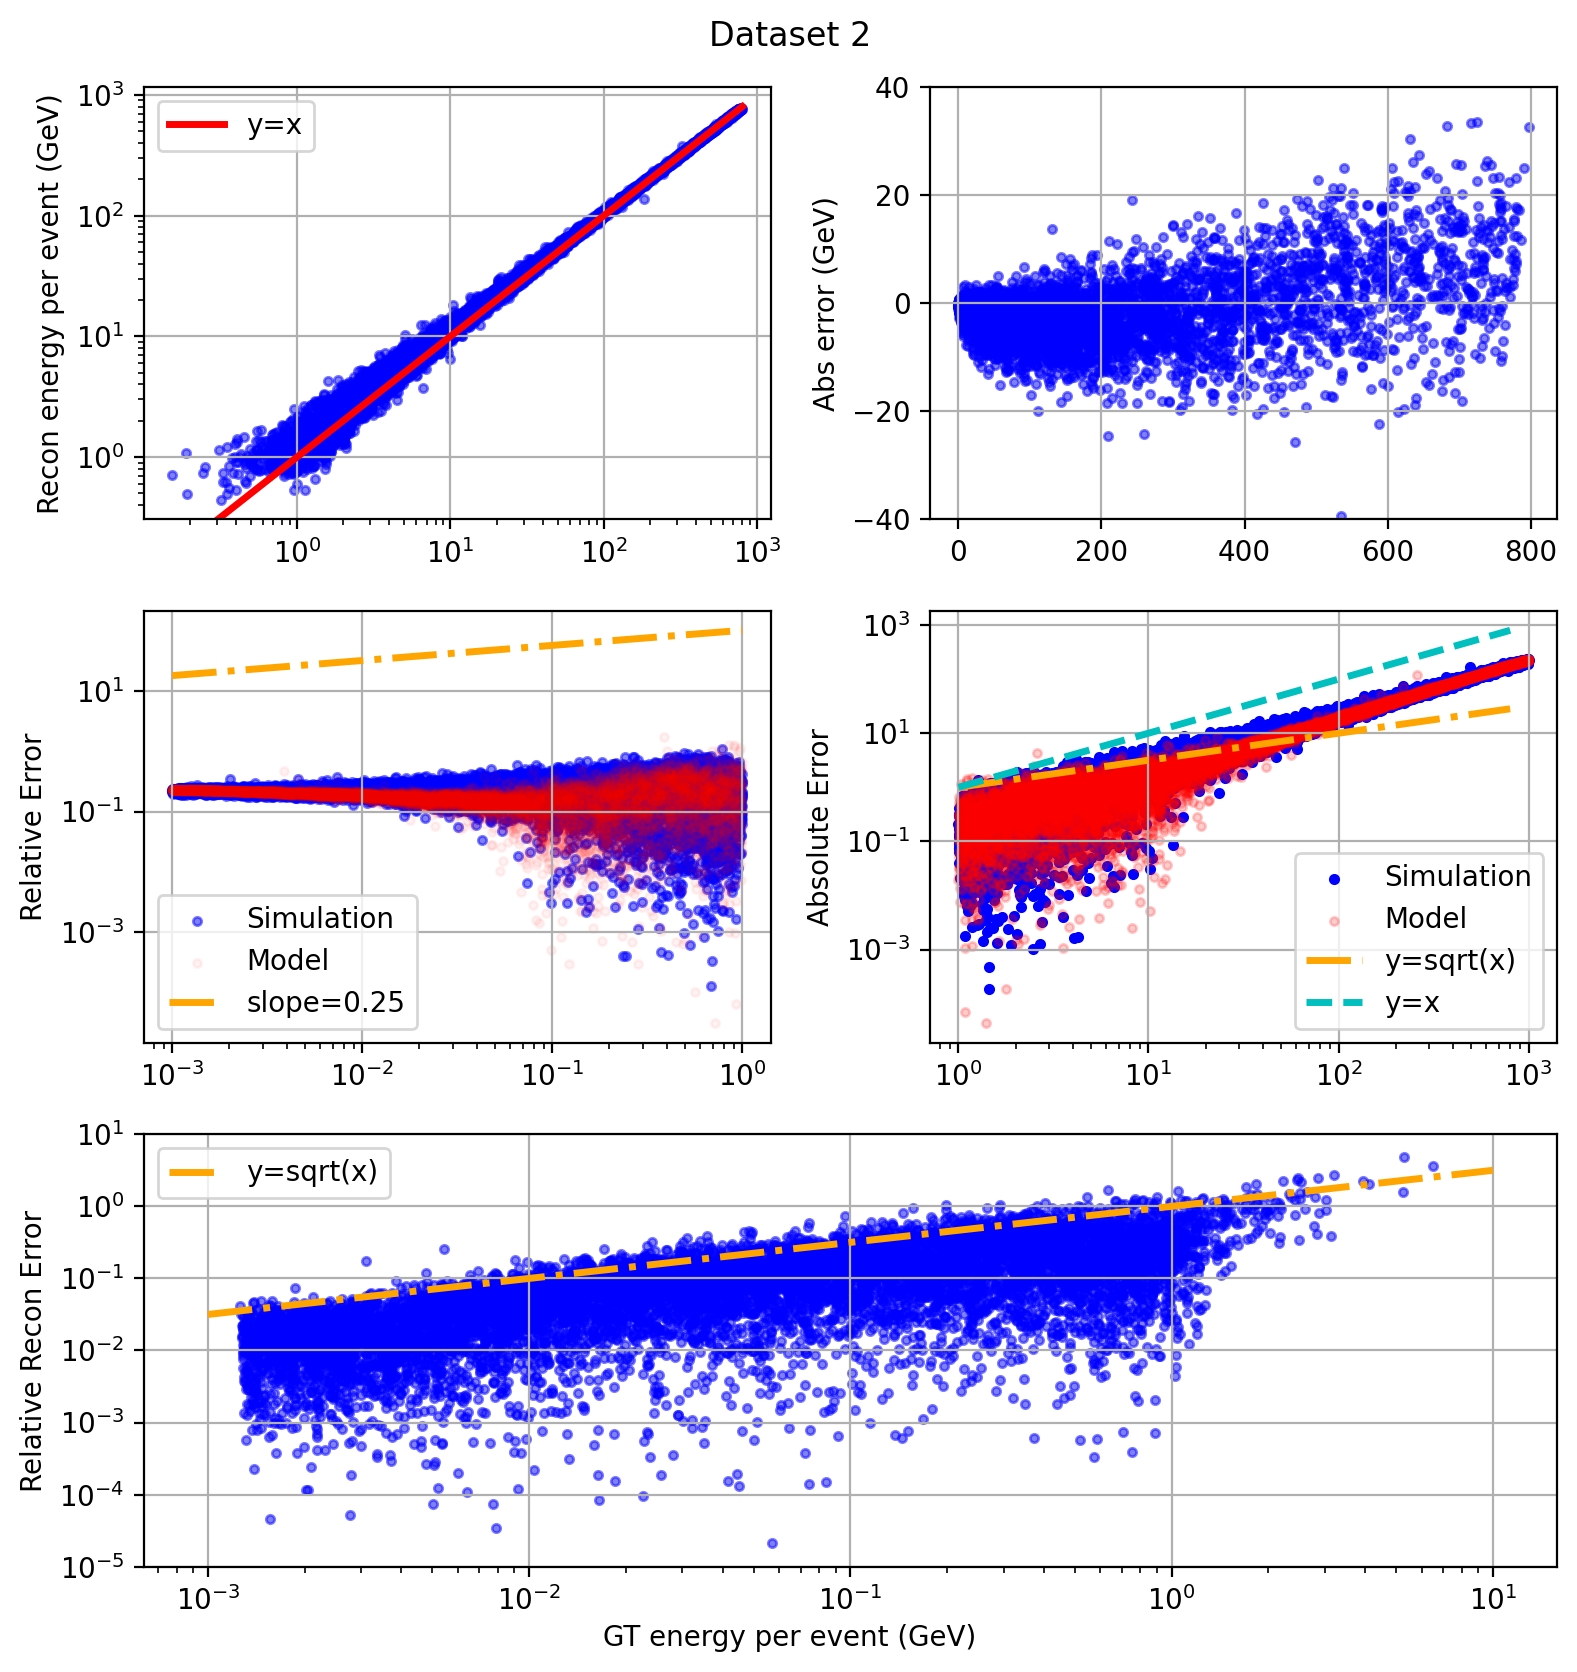

In [29]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='.', alpha=.5, color="b")
axes[0,1].set_ylabel("Abs error (GeV)")
axes[0,1].set_ylim([-40,40])
# axes[0,1].legend()
# axes[0,1].set_yscale('log')
axes[0,1].grid("True")

axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].plot([1e-3,1e0],np.power([1e-3,1e0],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()


# Merge the first row's axes
gs = axes[2, 0].get_gridspec()
for ax in axes[2, :]:
    ax.remove()
ax_big = fig.add_subplot(gs[2, :])
ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
ax_big.plot([1e-3,1e1],np.sqrt([1e-3,1e1])*np.power(1,3.5), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
ax_big.grid("True")
ax_big.set_yscale('log')
ax_big.set_xscale('log')
ax_big.legend()
ax_big.set_ylim([1e-5,1e1])
ax_big.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax_big.set_ylabel("Relative Recon Error")
plt.show()

In [30]:
#Energy

<Figure size 800x600 with 0 Axes>

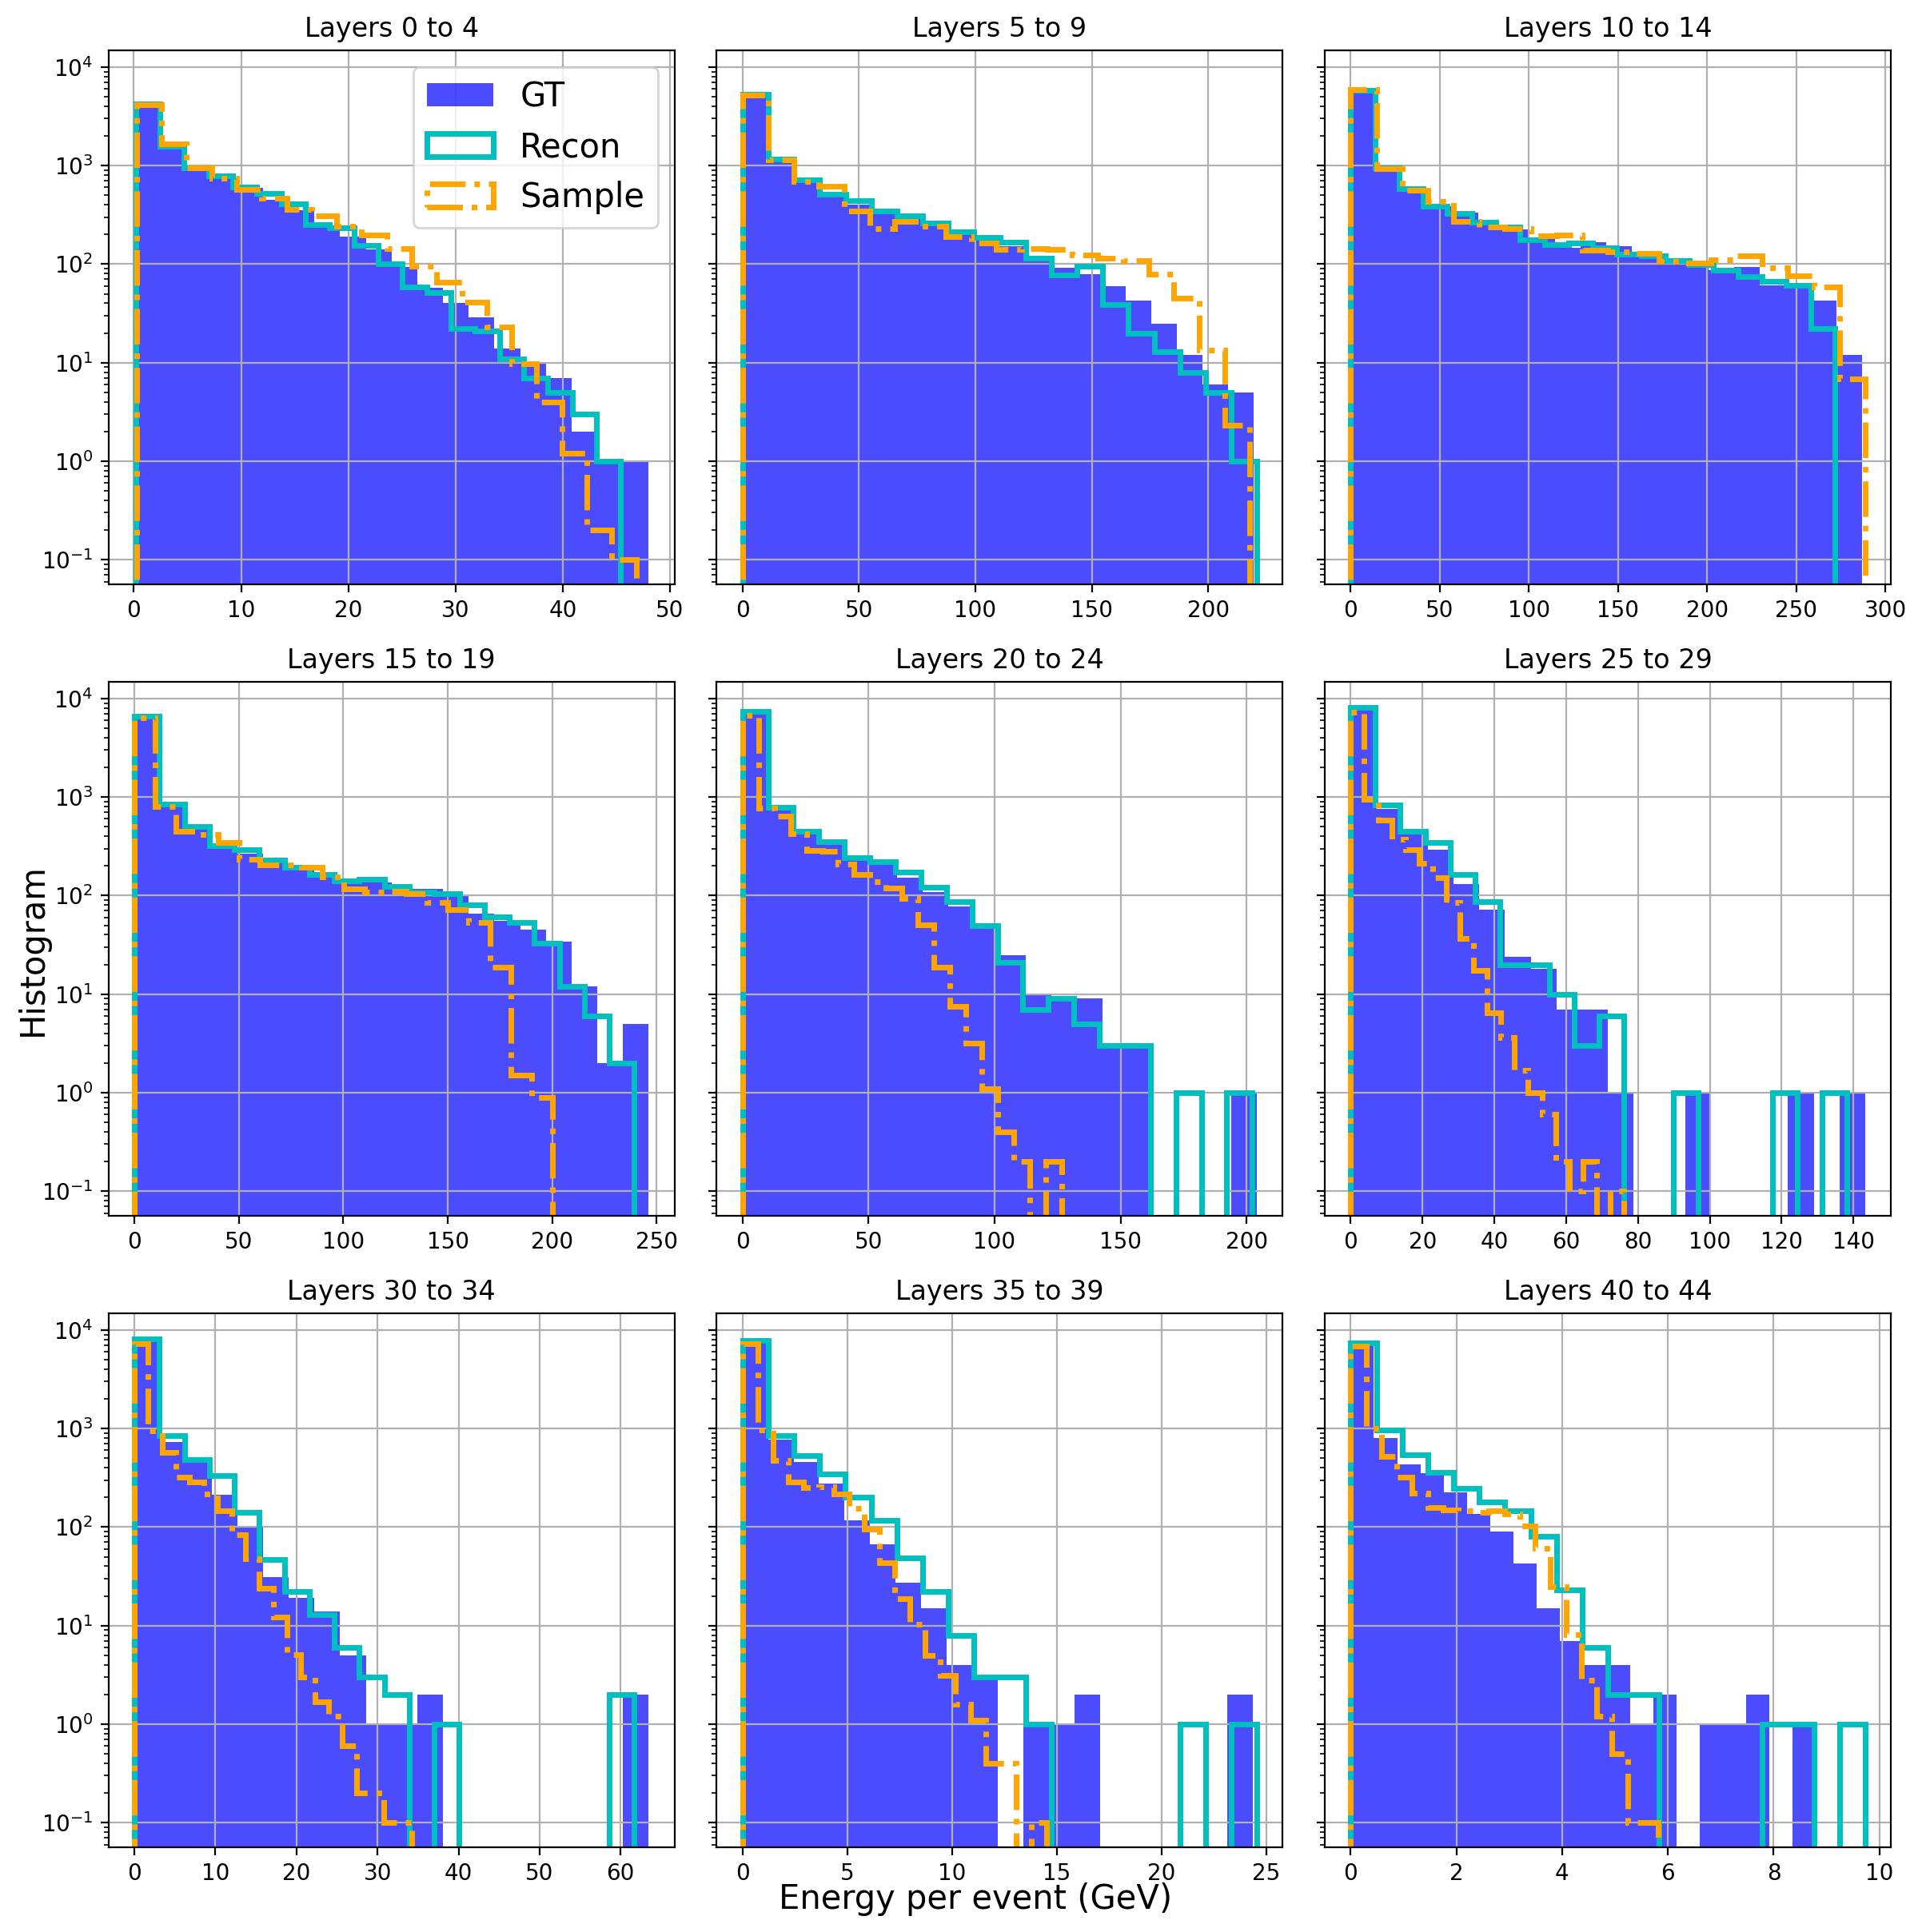

In [56]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]

# Create lists for the histogram values
target_counts, recon_counts, sample_counts = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)
target_bins, recon_bins, sample_bins = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    
    # Store the values of the histogram with the same normalization and bin sizes
    target_counts[i], target_bins[i] = np.histogram(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    recon_counts[i], recon_bins[i] = np.histogram(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    sample_counts[i], sample_bins[i] = np.histogram(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="c")
#     ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, weights = np.ones_like(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000) * 0.1, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")

    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [32]:
print(xtarget_samples.shape)

E_right = 12000 # MeV
E_left = 10000 # MeV
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
print(idxEnFilter.shape)
print(xtarget_samples, xtarget_samples.shape)
# print(entarget_samples[idxEnFilter])
print(xtarget_samples[idxEnFilter], xtarget_samples[idxEnFilter].shape)
len(idxEnFilter)

torch.Size([10000, 6480])
torch.Size([272])
tensor([[ 2.8870,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.4611,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.4747,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([10000, 6480])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.1645, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9786, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]) torch.Size([272, 6480])


272

tensor([[ 2.8870,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.4611,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.4747,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]])
torch.Size([10000, 6480]) torch.Size([4293])
Layer Size:  45
JSD Size:  45


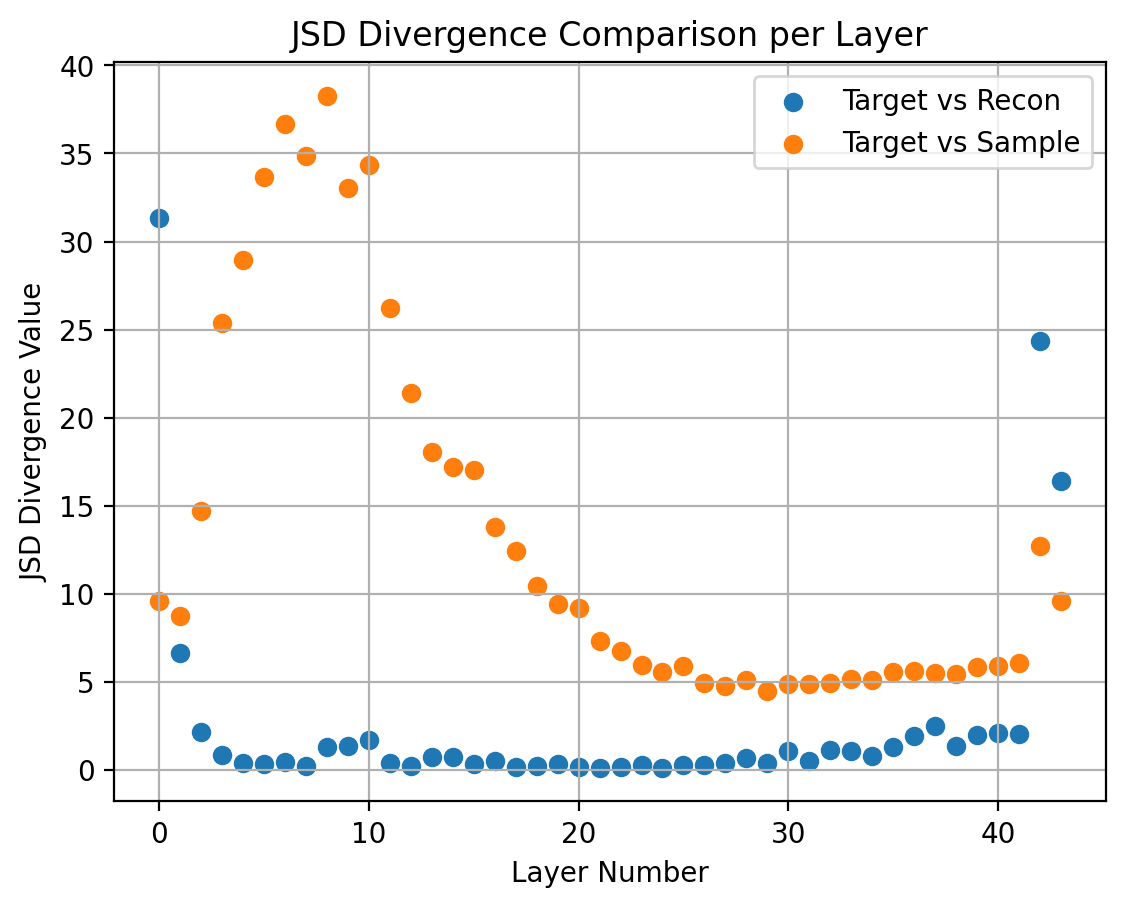

In [57]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros(45)
JSD_gen = np.zeros(45)

HLD_recon = np.zeros(45)
HLD_gen = np.zeros(45)

# Create lists for the histogram values
target_counts, recon_counts, gen_counts = [0] * 44, [0] * 44, [0] * 44
target_bins, recon_bins, gen_bins = [0] * 44, [0] * 44, [0] * 44

# Energy Ranges
E_right = 5000000000
E_left = 50000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]

# Energy filtered samples
print(xtarget_samples)
print(xtarget_samples.shape, idxEnFilter.shape)
# xtarget_samples, xrecon_samples, gen_samples = xtarget_samples[idxEnFilter], xrecon_samples[idxEnFilter], xgen_samples[idxEnFilter] # this line creates problems when running it again 

for i in range(44): # of layers in the cylinder - 1
    idx = (i+1)*9*16
    idxPrev = (i)*9*16
    l = idx - idxPrev
    
    target_counts[i], target_bins[i] = np.histogram((xtarget_samples[idxEnFilter])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    recon_counts[i], recon_bins[i] = np.histogram((xrecon_samples[idxEnFilter])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    gen_counts[i], gen_bins[i] = np.histogram((xgen_samples[idxEnFilter])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    
#     target_counts[i], target_bins[i] = np.histogram(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
#     recon_counts[i], recon_bins[i] = np.histogram(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
#     gen_counts[i], gen_bins[i] = np.histogram(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    
    mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
    mid_gen = 0.5 * (target_counts[i] + gen_counts[i])
    
#     print(mid_recon, target_counts[0].tolist())
    
#     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
#     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))
   
    JSD_recon[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
    JSD_gen[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))
    
    HLD_recon[i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
    HLD_gen[i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

print("Layer Size: ", layers.size)
print("JSD Size: ", len(JSD_recon))
plt.scatter(layers[:-1], np.asarray(JSD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(JSD_gen[:-1]))

plt.xlabel("Layer Number")
plt.ylabel("JSD Divergence Value")
plt.legend(["Target vs Recon", "Target vs Sample"])
plt.title("JSD Divergence Comparison per Layer")
plt.grid("True")
plt.show()

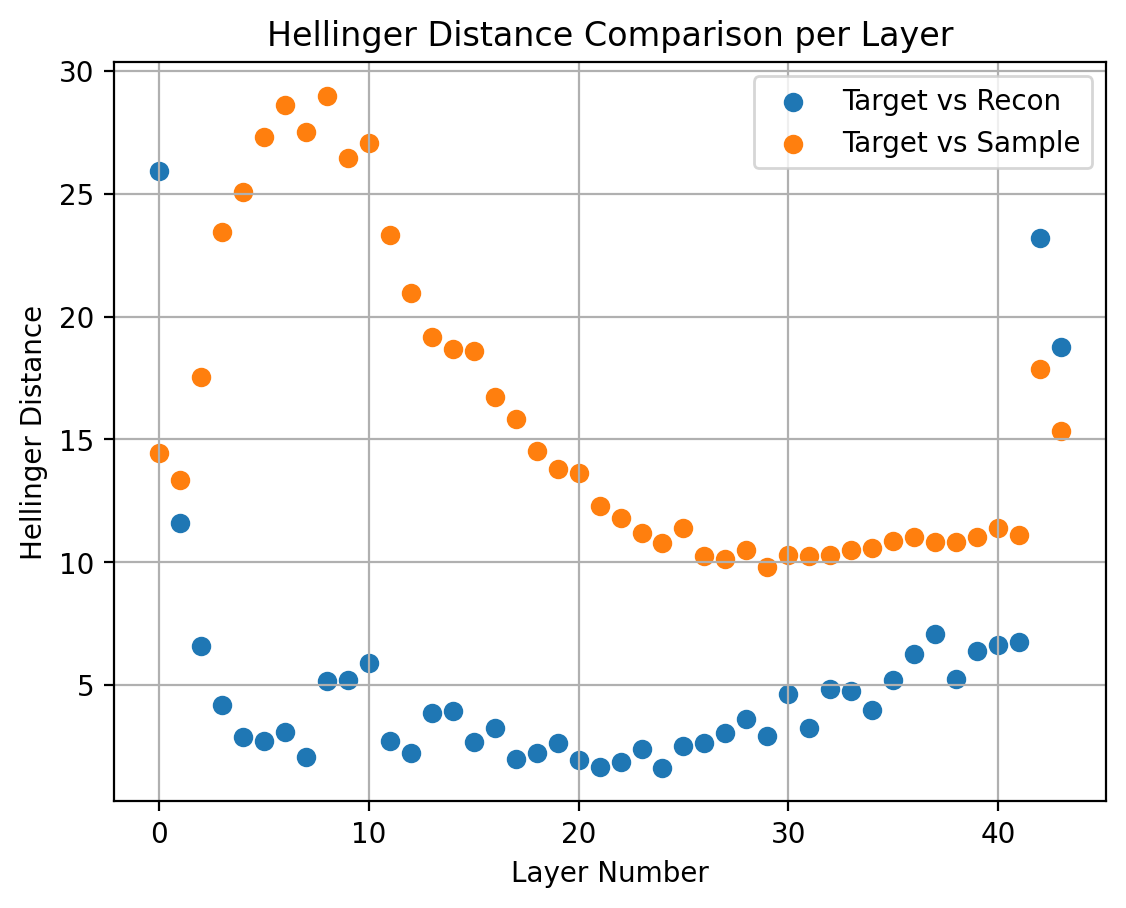

In [58]:
plt.scatter(layers[:-1], np.asarray(HLD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(HLD_gen[:-1]))

plt.xlabel("Layer Number")
plt.ylabel("Hellinger Distance")
plt.legend(["Target vs Recon", "Target vs Sample"])
plt.title("Hellinger Distance Comparison per Layer")
plt.grid("True")
plt.show()

[array([ 4, 17, 18, 38, 45, 30, 24, 21,  9,  4,  3,  5,  2,  0,  0,  1,  0,
        0,  0,  1]), array([ 6, 16, 32, 31, 42, 28, 18, 16,  9,  9,  8,  2,  1,  2,  0,  1,  0,
        0,  0,  1]), array([ 4, 12, 15, 16, 24, 28, 28, 27, 11, 18, 11,  9,  7,  4,  3,  2,  0,
        1,  1,  1]), array([ 1,  3,  7,  9, 15, 28, 19, 16, 27, 26, 17, 13, 11,  8, 11,  3,  5,
        1,  1,  1]), array([ 1,  5,  8, 12, 18, 15, 22, 31, 26, 14, 19, 11, 20,  9,  6,  3,  1,
        0,  0,  1]), array([ 3,  1,  4, 13, 13, 17, 26, 22, 22, 24, 20, 17, 12, 15,  7,  4,  1,
        0,  0,  1]), array([ 2,  2,  2,  7, 11, 13, 16, 21, 18, 22, 21, 23,  8, 24, 15,  9,  4,
        3,  0,  1]), array([ 2,  0,  1,  5,  4,  9, 13, 25, 15, 16, 19, 33, 16, 28, 15, 13,  5,
        2,  0,  1]), array([ 2,  0,  0,  0,  1,  5,  8,  9, 15, 20, 14, 19, 17, 26, 26, 26, 17,
       10,  4,  3]), array([ 1,  1,  0,  0,  0,  3,  7,  6, 11, 15, 14, 24, 20, 26, 29, 28, 22,
       10,  2,  3]), array([ 1,  0,  0,  1,  0,  1,  2,  2, 

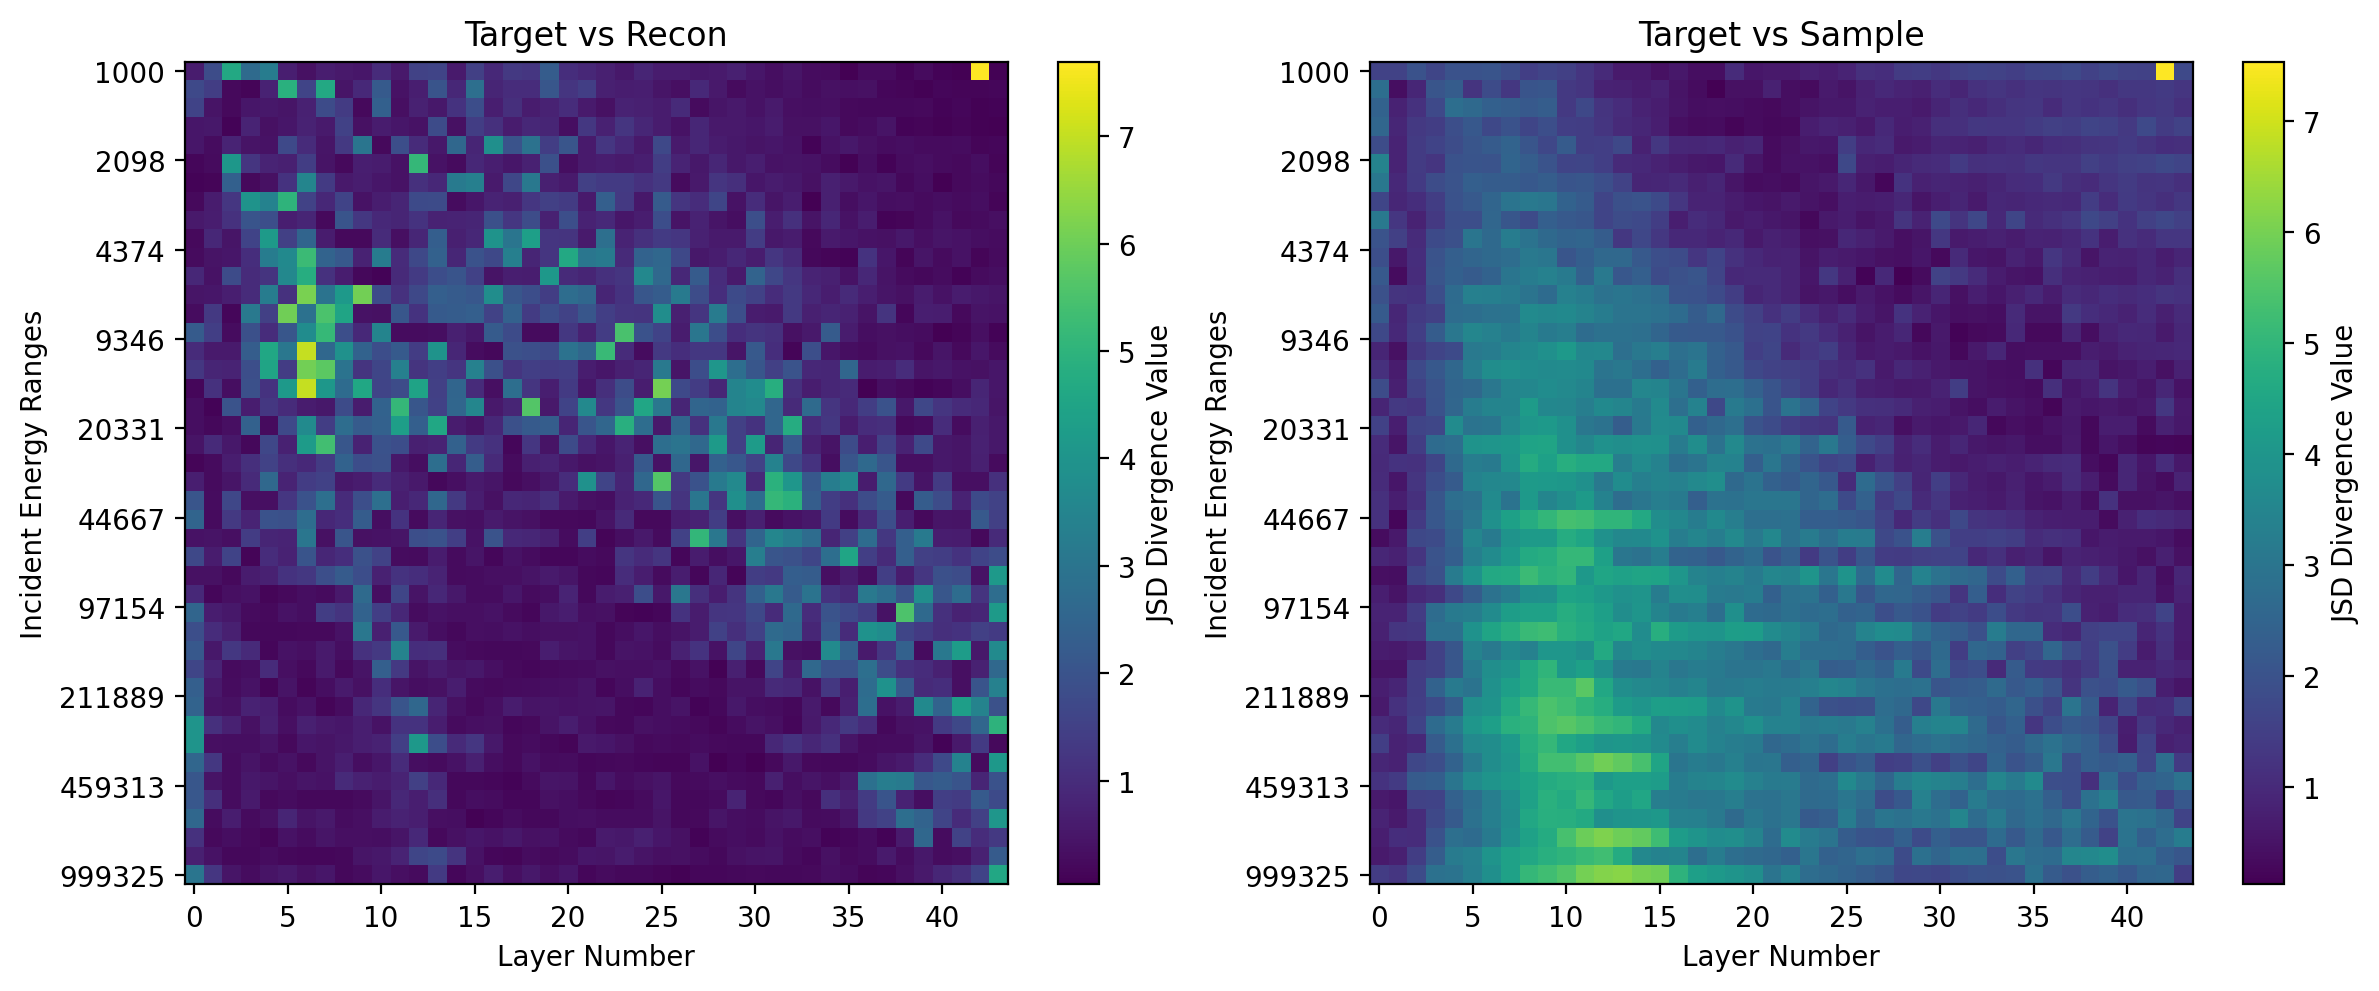

In [35]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0
from mpl_toolkits.axes_grid1 import make_axes_locatable

samps = np.linspace(0, len(entarget_samples) - 1, 10)

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros([44,44])
JSD_gen = np.zeros([44,44])

HLD_recon = np.zeros([44,44])
HLD_gen = np.zeros([44,44])

# Sort samples
entarget_samplesnp = entarget_samples.numpy()
ind = np.argsort(entarget_samplesnp, axis = 0).flatten()
sortentarget_samples = entarget_samples[ind]
sortxtarget_samples = xtarget_samples[ind]
sortxrecon_samples = xrecon_samples[ind]
sortxgen_samples = xgen_samples[ind]
inc_energies = np.linspace(0, len(entarget_samples), 46).astype(int)

xenergies = (((sortentarget_samples[samps] / 1).flatten()).numpy().astype(int)).tolist()

for j in range(44):
    
    # Create lists for the histogram values
    target_counts, recon_counts, gen_counts = [0] * 44, [0] * 44, [0] * 44
    target_bins, recon_bins, gen_bins = [0] * 44, [0] * 44, [0] * 44

    
    sub_target_samples = sortxtarget_samples[inc_energies[j] : inc_energies[j+1]]
    sub_recon_samples = sortxrecon_samples[inc_energies[j] : inc_energies[j+1]]
    sub_gen_samples = sortxgen_samples[inc_energies[j] : inc_energies[j+1]]
    for i in range(44): # of layers in the cylinder - 1
#         print(sub_target_samples, sub_target_samples.shape)
        idx = (i+1)*9*16
        idxPrev = (i)*9*16
        l = idx - idxPrev
#         target_counts[i], target_bins[i] = np.histogram(((sub_target_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
#         recon_counts[i], recon_bins[i] = np.histogram(((sub_recon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
#         gen_counts[i], gen_bins[i] = np.histogram(((sub_gen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
        
        target_counts[i], target_bins[i] = np.histogram((sub_target_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        recon_counts[i], recon_bins[i] = np.histogram((sub_recon_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        gen_counts[i], gen_bins[i] = np.histogram((sub_gen_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)

        
        mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
        mid_gen = 0.5 * (target_counts[i] + gen_counts[i])

    #     print(mid_recon, target_counts[0].tolist())

    #     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
    #     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))

        JSD_recon[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
        JSD_gen[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))

        HLD_recon[j][i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
        HLD_gen[j][i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

    if j == 43:
        print(target_counts, len(target_counts))
        
# print(JSD_recon)
# print(min(JSD_recon.flatten()))
print(JSD_recon, JSD_recon.shape)

# Plotting for JSD_recon and JSD_gen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for JSD_recon
cax1 = ax1.imshow(JSD_recon, interpolation='nearest', cmap='viridis')
ax1.set_aspect('equal')
ax1.set_title('Target vs Recon')
ax1.set_yticks(np.linspace(0, 43, 10))
ax1.set_yticklabels([int(x) for x in xenergies])
ax1.set_ylabel("Incident Energy Ranges")
ax1.set_xlabel("Layer Number")
divider1 = make_axes_locatable(ax1)
cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
cbar1.set_label('JSD Divergence Value')

# Plot for JSD_gen
cax2 = ax2.imshow(JSD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_title('Target vs Sample')
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('JSD Divergence Value')

plt.tight_layout()
plt.show()

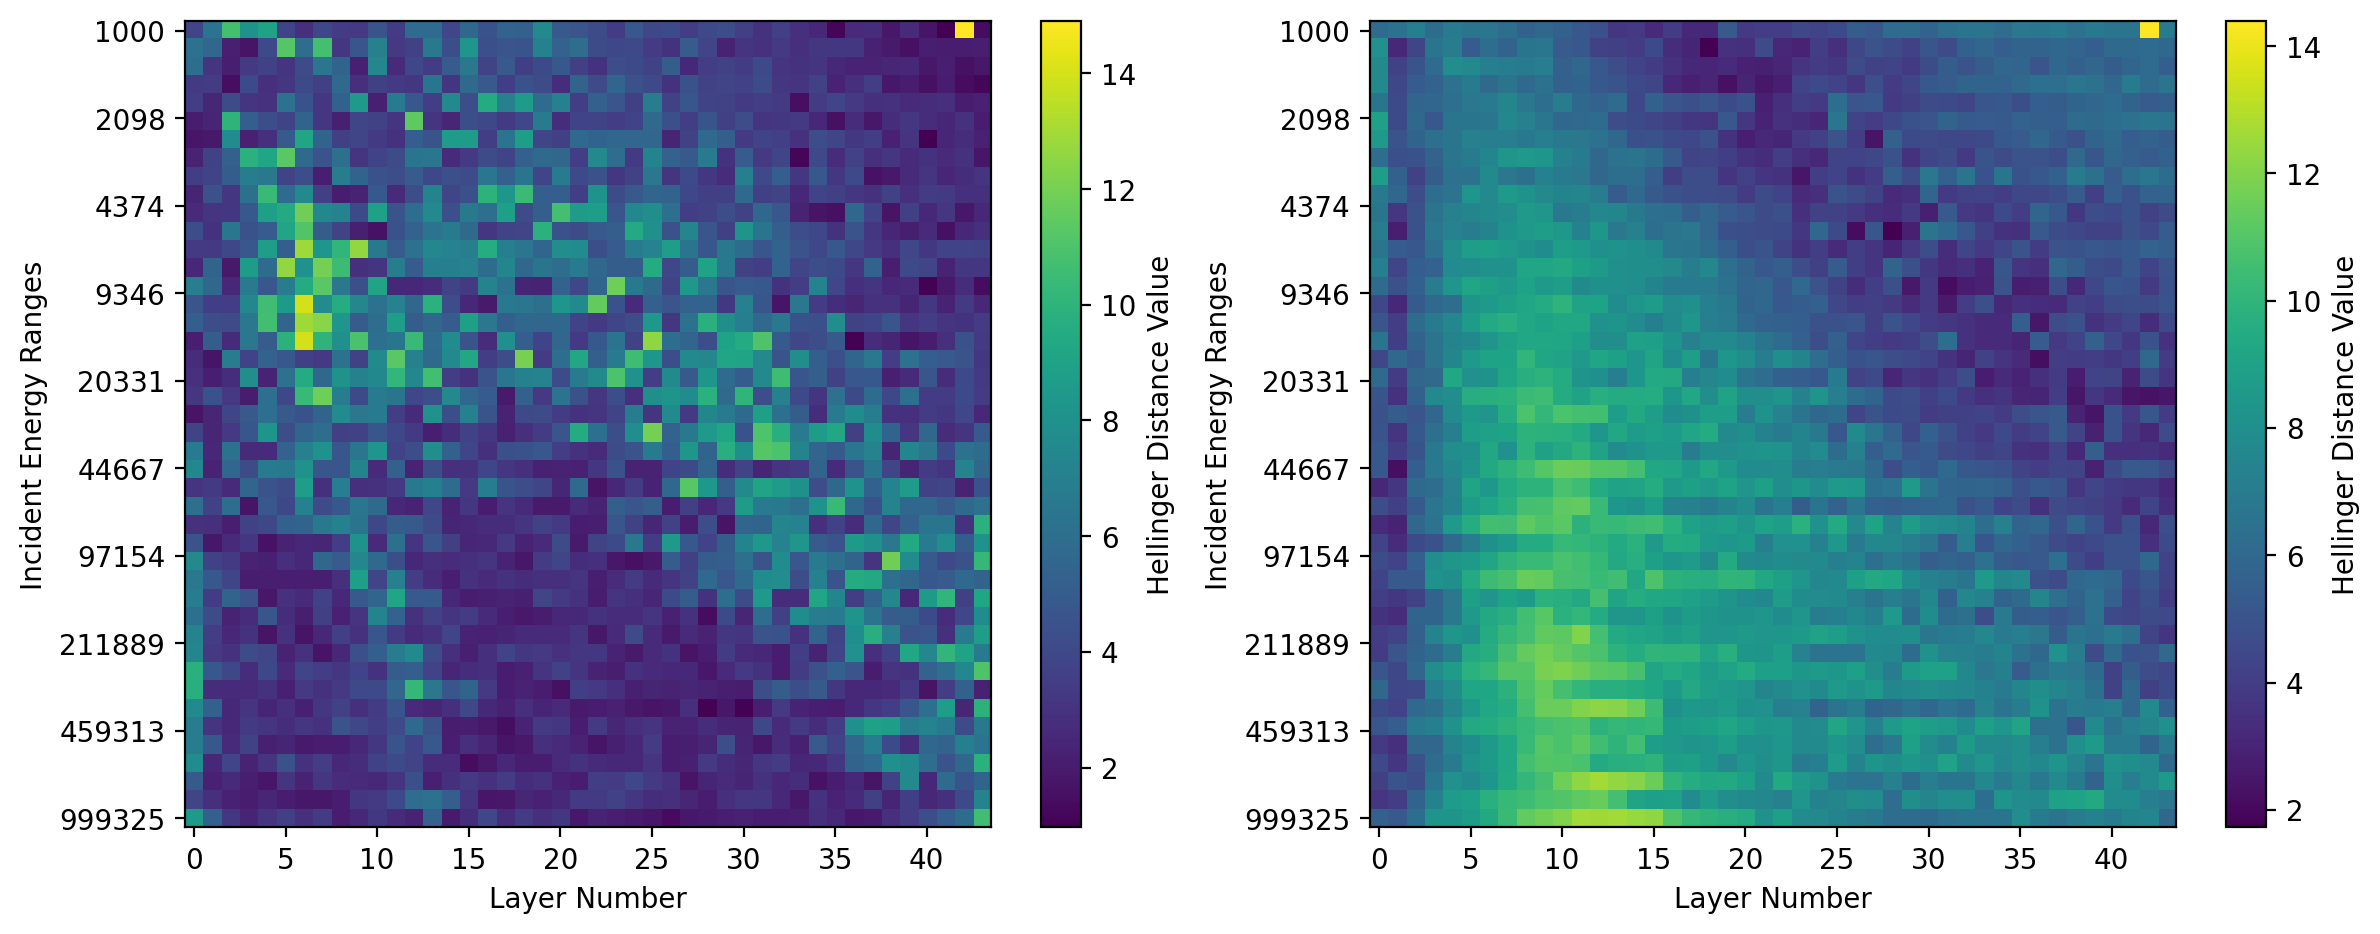

In [36]:
# Plotting for HLD_recon and HLD_gen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for HLD_recon
cax1 = ax1.imshow(HLD_recon, interpolation='nearest', cmap='viridis')
ax1.set_aspect('equal')
ax1.set_yticks(np.linspace(0, 43, 10))
ax1.set_yticklabels([int(x) for x in xenergies])
ax1.set_ylabel("Incident Energy Ranges")
ax1.set_xlabel("Layer Number")
divider1 = make_axes_locatable(ax1)
cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
cbar1.set_label('Hellinger Distance Value')

# Plot for HLD_gen
cax2 = ax2.imshow(HLD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('Hellinger Distance Value')

plt.tight_layout()
plt.show()


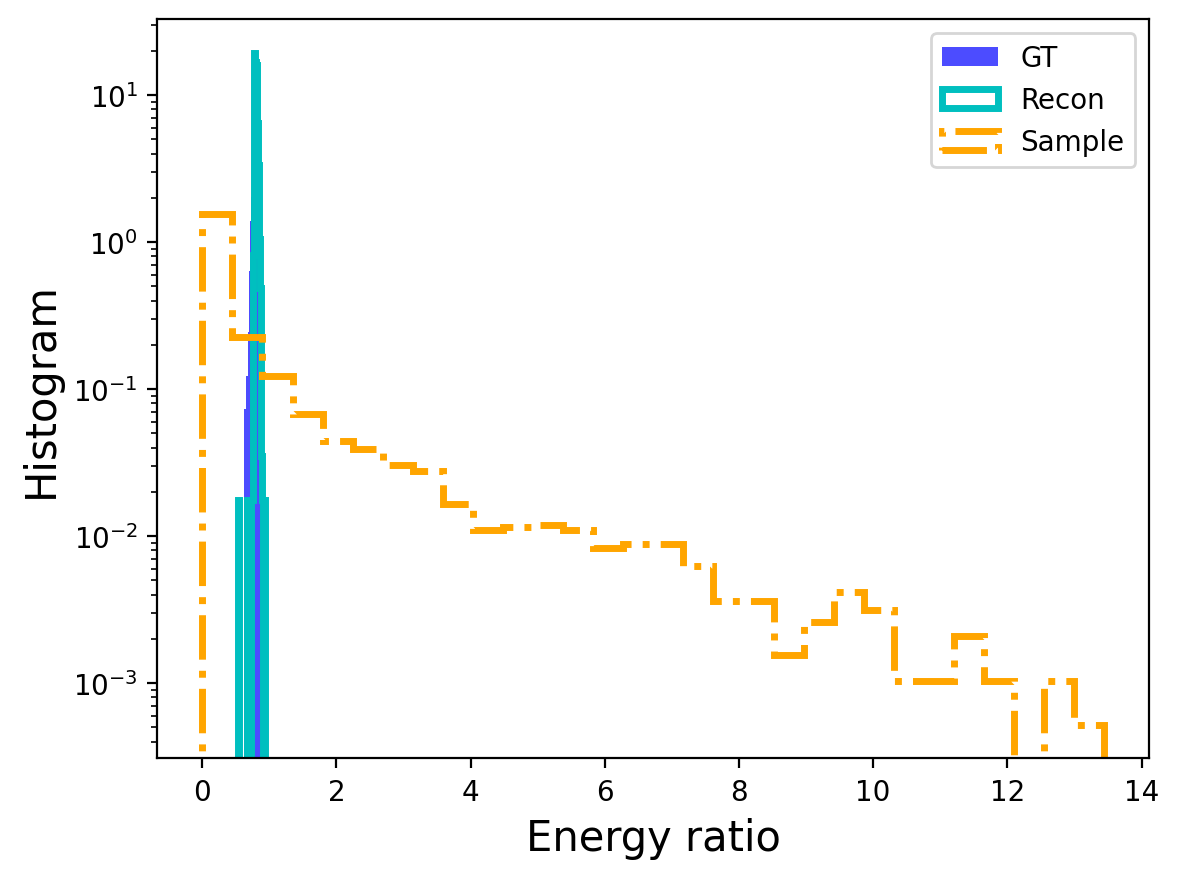

In [37]:
plt.hist((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
plt.hist((xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="c", density=True)
plt.hist((xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)

plt.xlabel("Energy ratio", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_ration_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

# Energy across all voxels throughout the cylinder / incidence energy

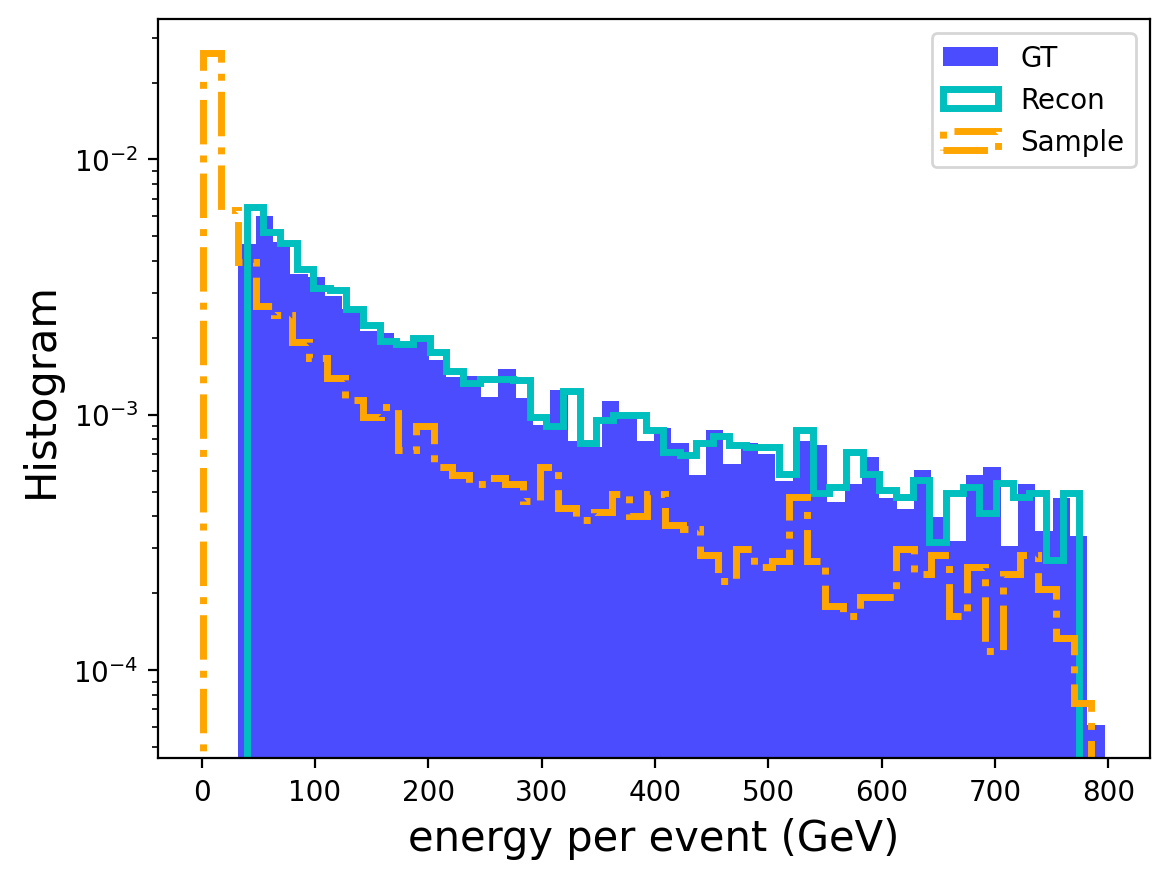

In [38]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', linewidth=2.5, color="c", density=True)
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)
# plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", density=True)

plt.xlabel("energy per event (GeV)", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
# plt.title(f'{ds[part]} \n {E_left/1000}<E_inc<{E_right/1000} (GeV)')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

<Figure size 800x600 with 0 Axes>

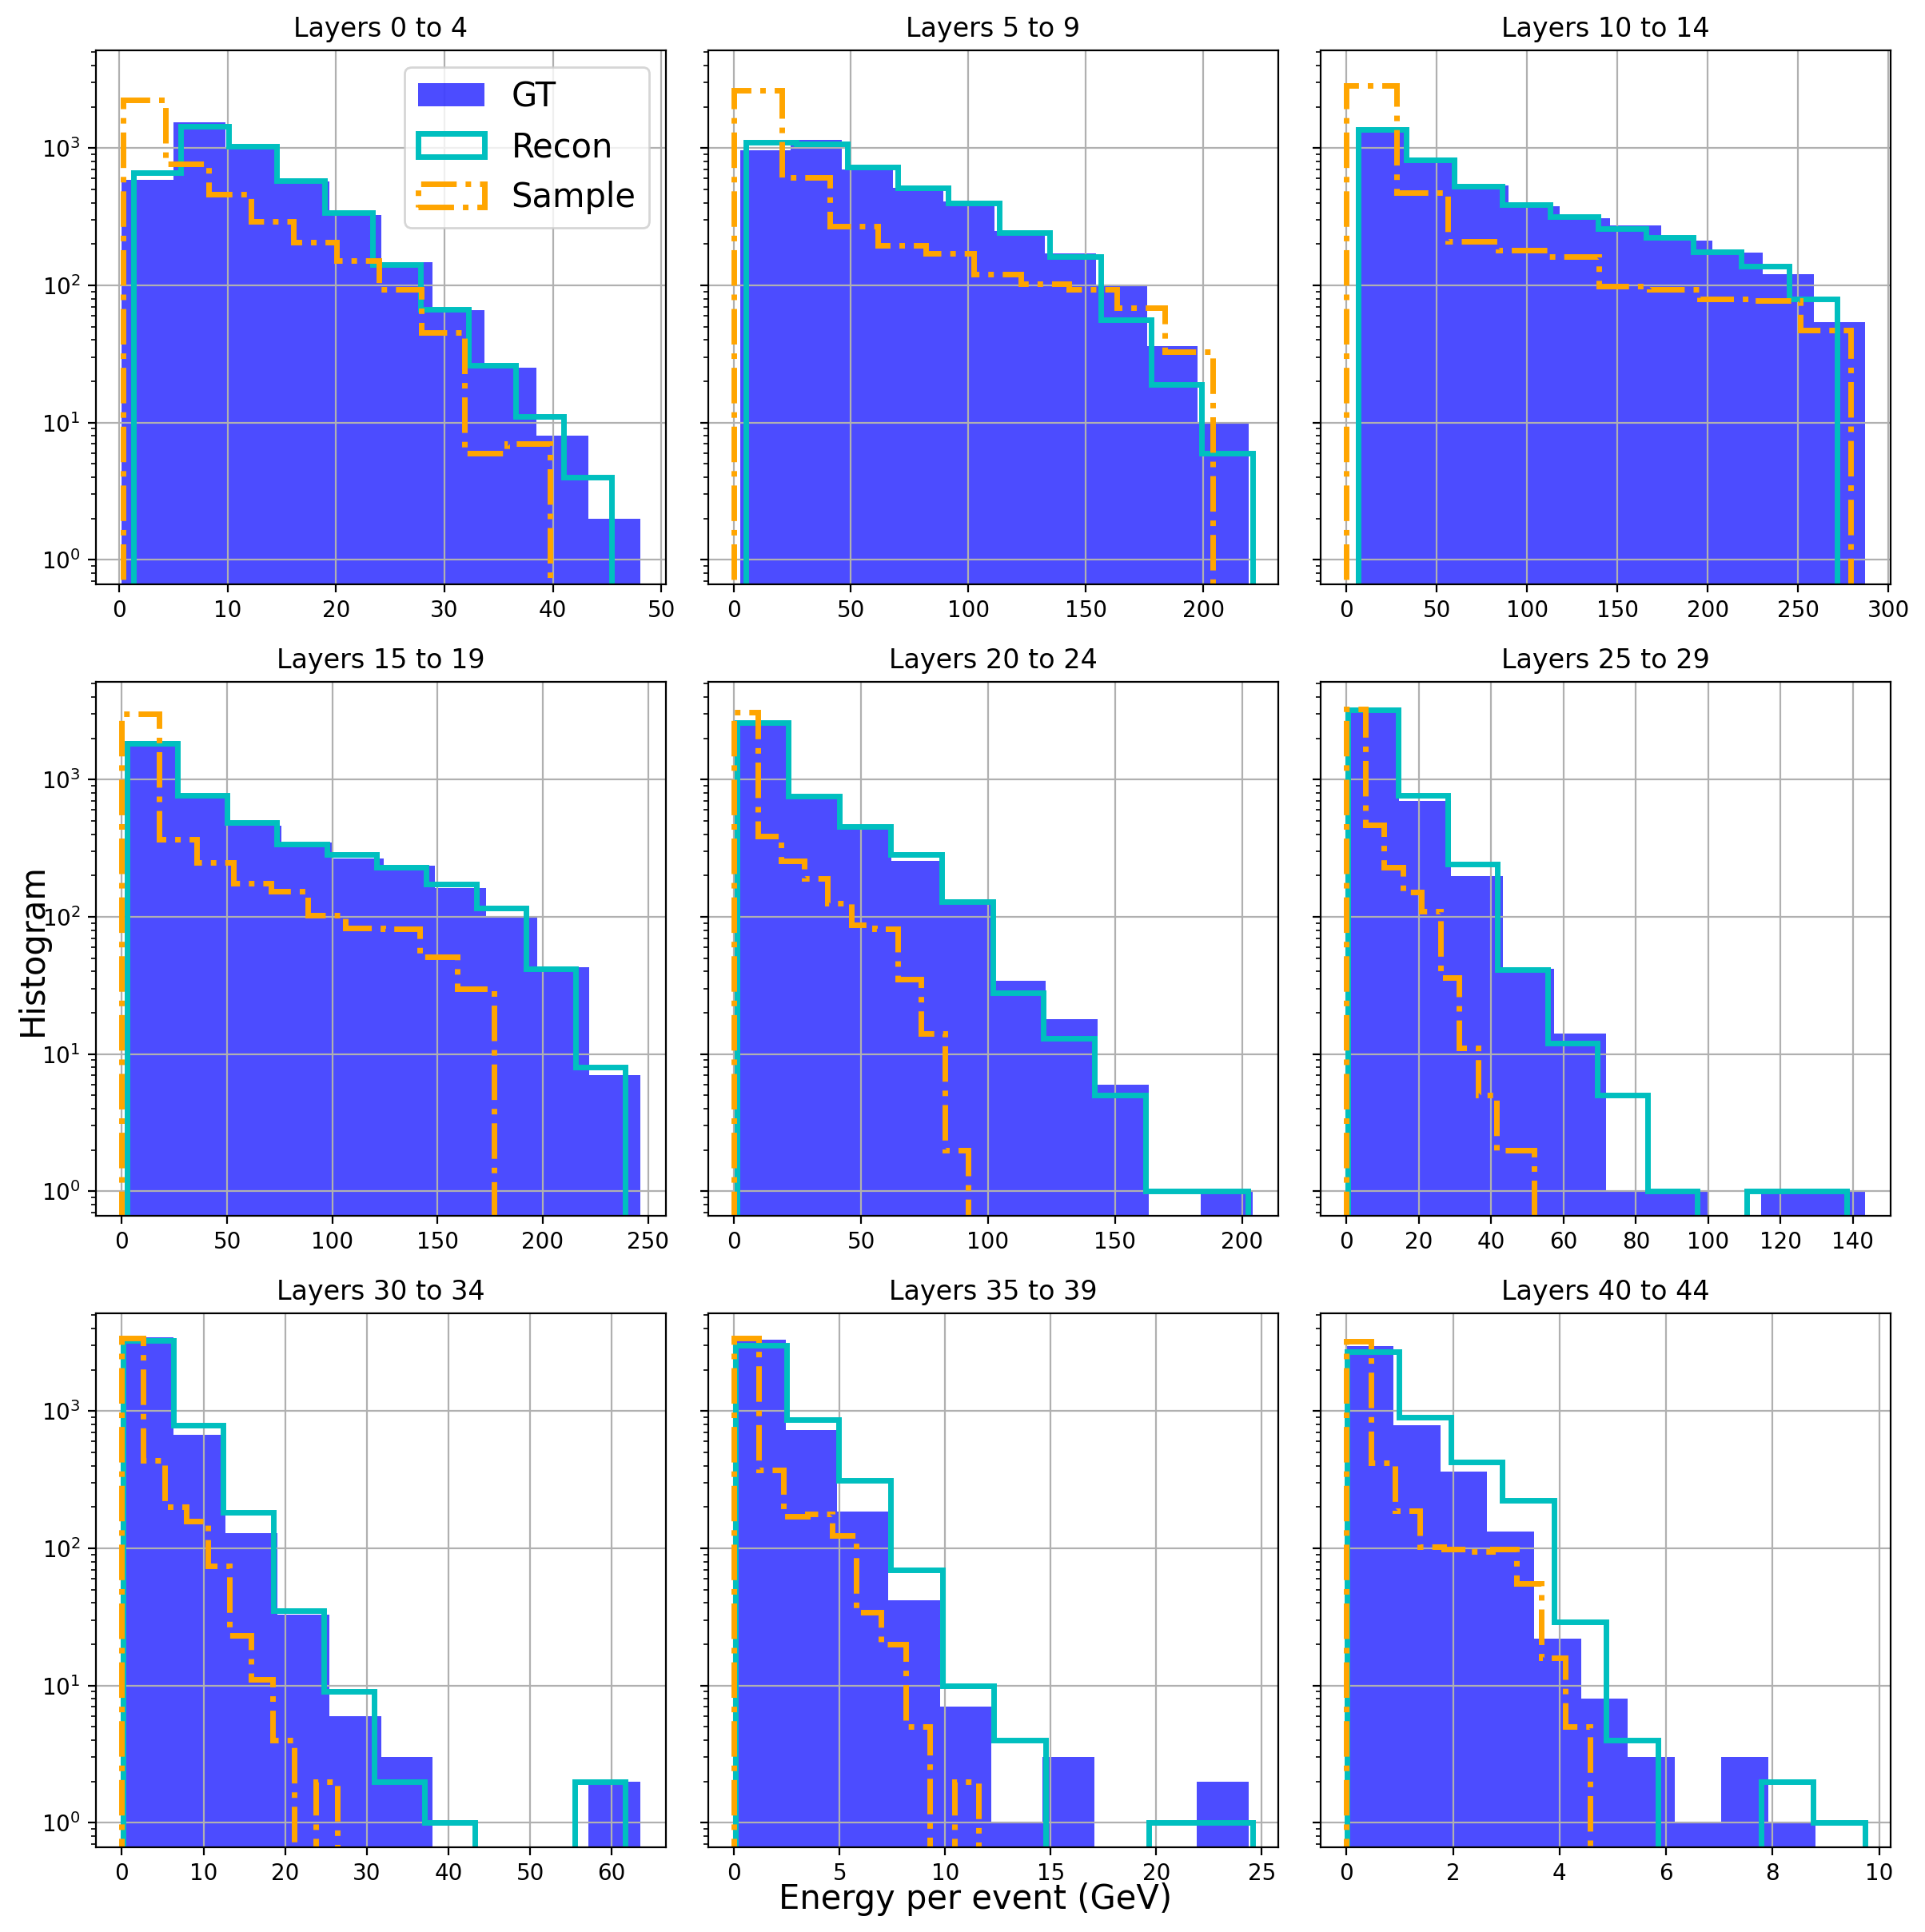

In [39]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=10, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=10, log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=10, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [40]:
(((xtarget_samples - xrecon_samples)/(xtarget_samples+1e-5))**2).sum(dim=1).argsort()[-200:-1]

tensor([5589, 9069, 8504, 6865, 3819, 6182, 4191, 8778, 4444, 4857, 4472, 9775,
        9110, 4579, 9066, 3762, 3975, 6519, 2055, 2941, 5410, 3371, 7455, 1694,
        2260, 5263, 5512, 2006, 3056, 1356, 9122, 1864, 8920, 5417, 8960, 8139,
        2637, 4984, 6567, 5100, 2060, 5542, 5158, 2984, 1790, 3472, 9308,  458,
        1450, 2476, 5028, 2909,  809,  130, 9469, 6443, 2660,  138, 4501, 3505,
        8282,  579, 1569, 4195, 8910,  937, 6452, 6573, 3621, 6821, 7013, 8385,
        3658, 3267, 4487, 9294, 8740, 7790, 1981, 5175,  906, 3222, 2311, 9733,
        7079,  248, 8368, 9874, 8782, 2403, 2936, 6948, 2604, 7347, 1361,  222,
         482, 6897,  781, 7534, 5685, 7322, 6652, 3444, 6227, 8533, 6345,  253,
        8758, 5804, 7073, 9776, 7797, 5233, 1032, 6596, 6971, 3835, 7438, 9435,
        3979, 8441, 7350, 1776, 6330, 1586, 2279, 8817, 9055,  827, 7149, 9230,
        9428, 6874,  735, 2014, 3409,  532, 6534, 4720,  309, 6823, 4401, 9142,
        3214, 1604, 6815, 8832, 5488, 21

In [41]:
print(xtarget_samples, xtarget_samples.shape)
print(entarget_samples, entarget_samples.shape)
# print(entarget_samples[entarget_samples[9500 < ]])

spec_energy = 100000 #MeV
diff_energy = abs(entarget_samples - spec_energy)
print(entarget_samples[torch.nonzero(diff_energy == min(diff_energy))[0][0]])
idx = torch.nonzero(diff_energy == min(diff_energy))[0][0].item()
print(idx)

tensor([[ 2.8870,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.4611,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.4747,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([10000, 6480])
tensor([[  2128.1135],
        [  3865.5706],
        [256267.9375],
        ...,
        [688751.9375],
        [145378.1875],
        [  6909.7441]]) torch.Size([10000, 1])
tensor([99934.4219])
8305


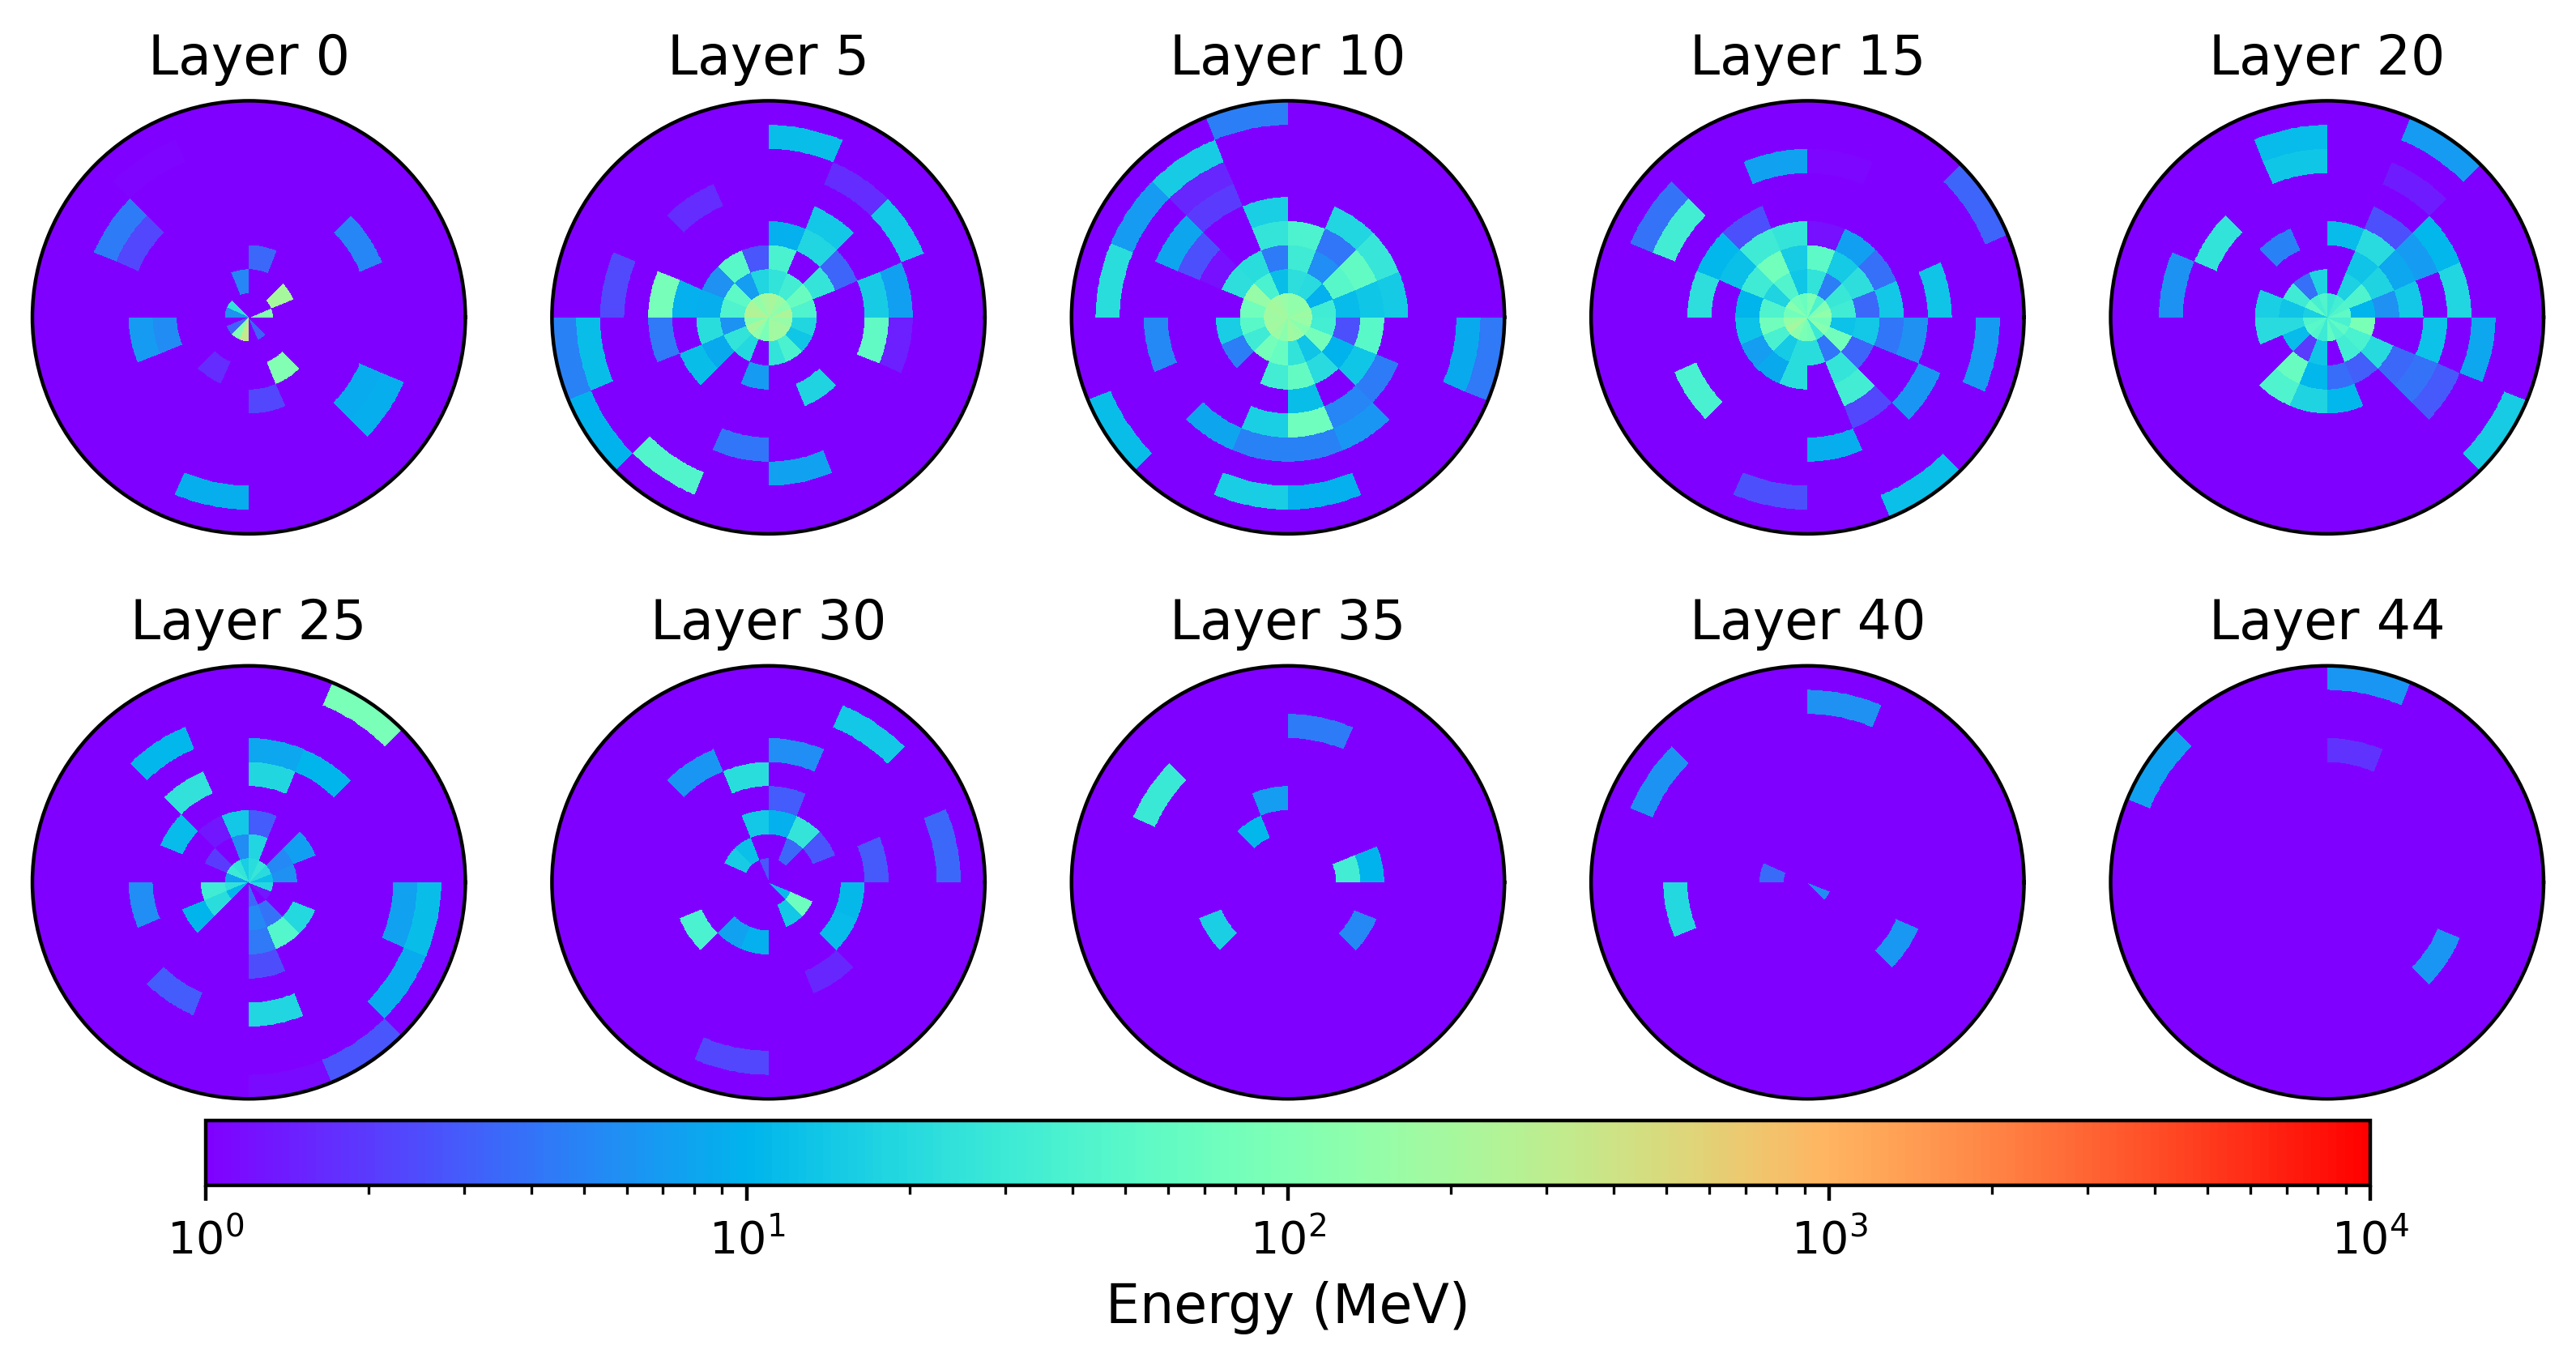

In [42]:
import os

dir = f'/home/luian1/CaloQVAE/figs/{modelname}'
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]

if not os.path.exists(dir):
    os.makedirs(dir)

HLF_1_electron.DrawSingleShower(xtarget_samples[idx,:].detach().cpu().numpy(), filename=f'/home/luian1/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(xtarget_samples[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

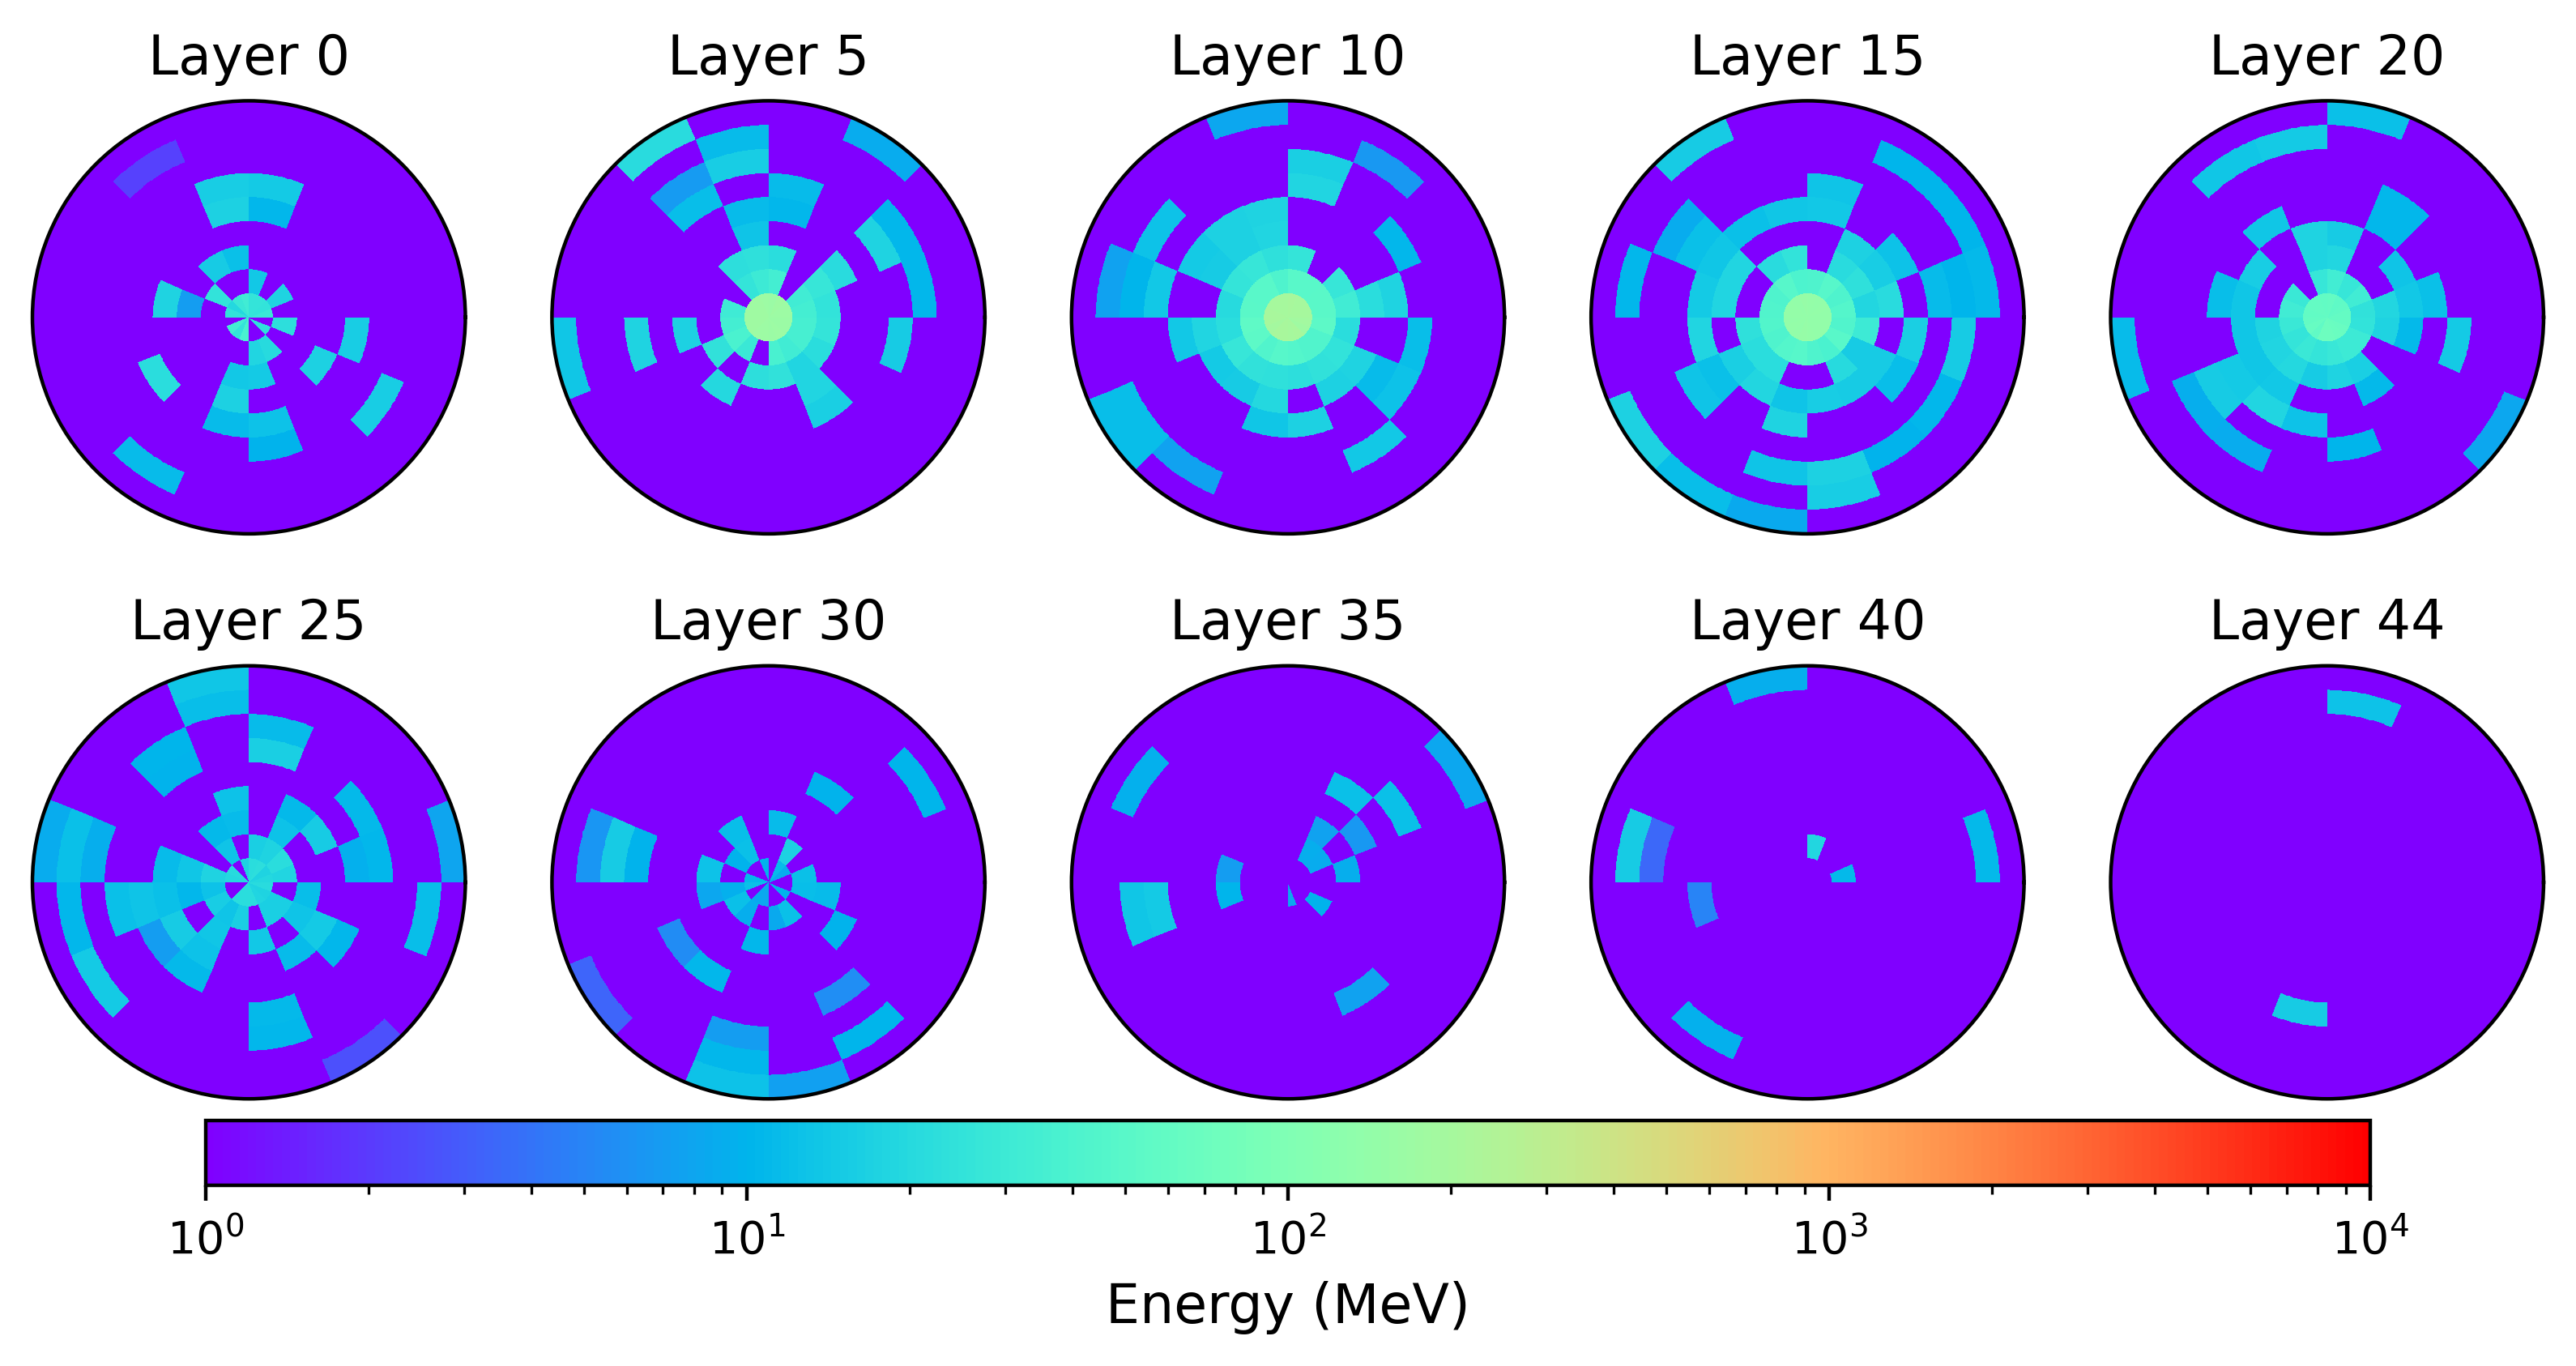

In [43]:
HLF_1_electron.DrawSingleShower(xrecon_samples[idx,:].detach().cpu().numpy(), filename=f'/home/luian1/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(xrecon_samples[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

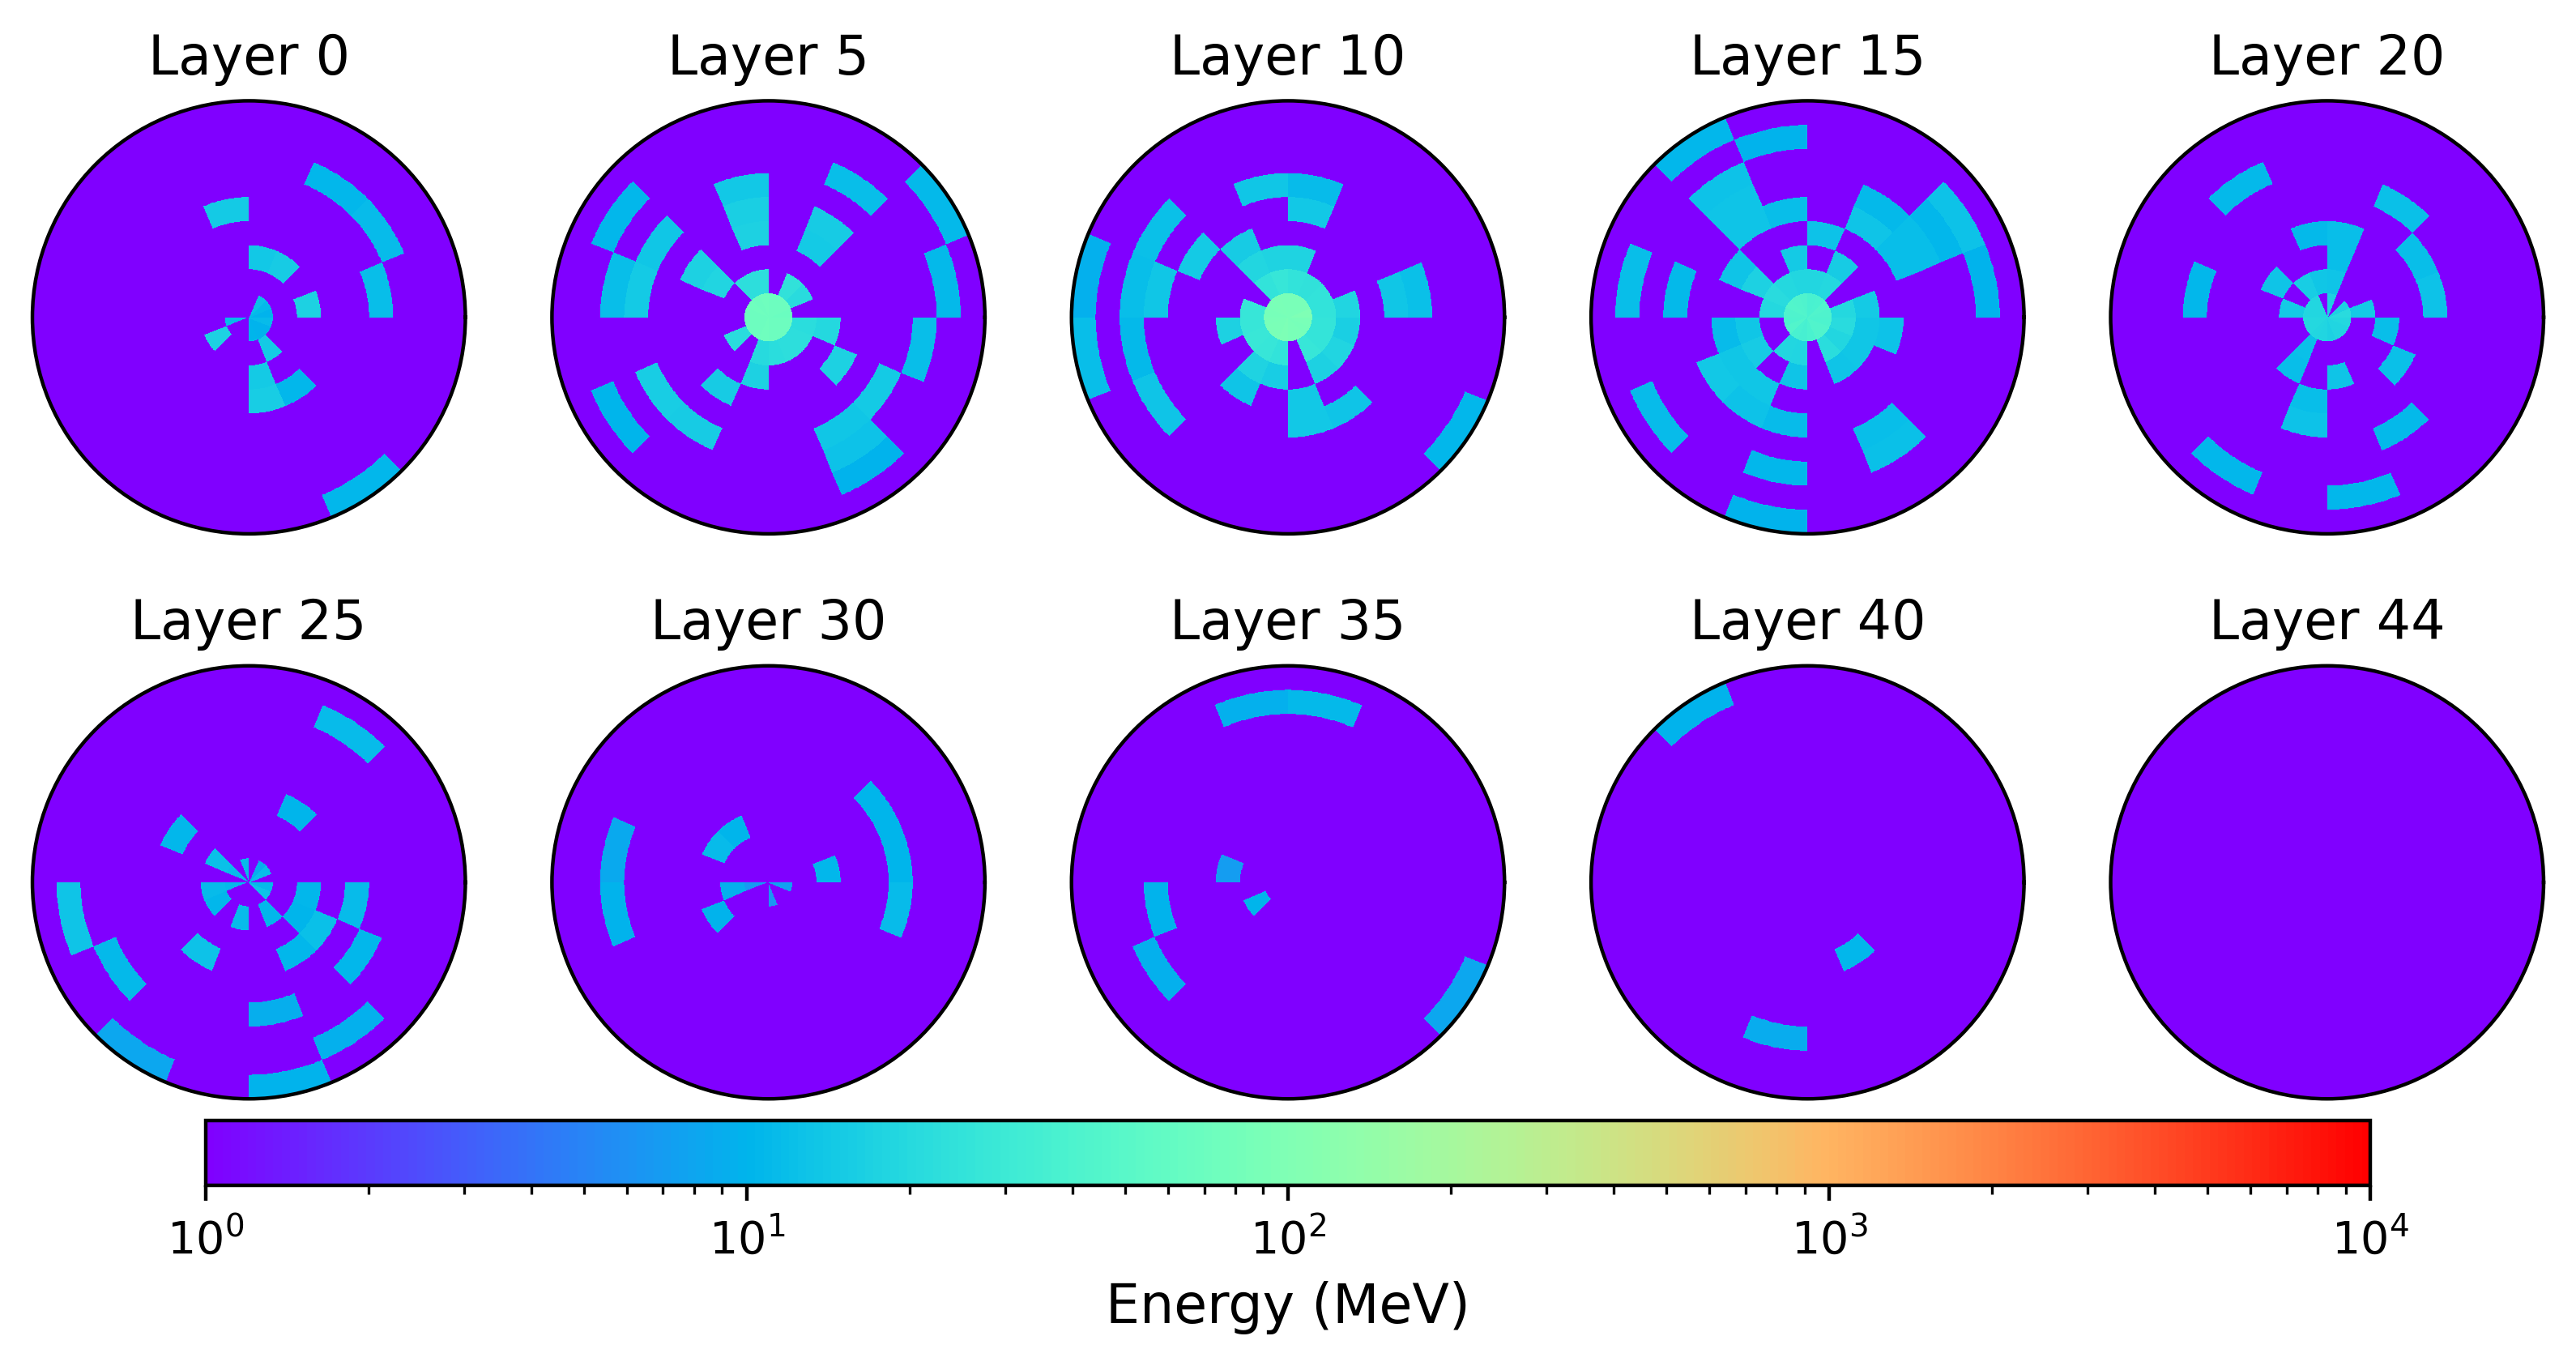

In [44]:
HLF_1_electron.DrawSingleShower(xgen_samples[idx,:].detach().cpu().numpy(), filename=f'/home/luian1/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(xgen_samples[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

In [45]:
# Use test dataset /fast_scratch/QVAE/test_data/dataset_2_2.hdf5
# array from hdf5 -> convert to torch tensor

In [46]:
xtarget_samples = []
xrecon_samples = []
xgen_samples = []
scaled = True
entarget_samples = []

def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v
            
# for xx in train_loader:
for xx in new_test_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
#     fwd_output = engine.model((in_data, true_energy), False)
    
#     if scaled:
#         in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        
        
#         recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        
        ## This is how youi generate data using model
        # ================================
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples_qpu(num_samples=128, true_energy=true_energy[:128])
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        # ================================
    
    else:
        raise Exception("Script only supports scaled dataset at the moment...")


    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

IndentationError: unexpected indent (1782842665.py, line 26)

In [ ]:
samp = next(iter(val_loader))

In [ ]:
samp[0][0].shape